In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as tick
import astropy.cosmology
import scipy.stats
import scipy.interpolate
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG
import socket

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [4]:
from astropy.cosmology import Planck15 as cosmo

print(cosmo.__doc__,'\n')
cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1
print(cosmo)

Planck15 instance of FlatLambdaCDM cosmology

(from Planck Collaboration 2016, A&A, 594, A13 (Paper XIII), Table 4 (TT, TE, EE + lowP + lensing + ext)) 

FlatLambdaCDM(name="Planck15 H0 = 100", H0=100 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)


In [5]:
data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")
# print(os.environ)

lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

name = socket.gethostname()
print(name)

if name == 'DESKTOP-RB5C8OC': 
    file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
elif name == 'LaNaranjaDos':
    file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
else: raise Exception('Device not configured for hdf5 data load')

LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

DESKTOP-RB5C8OC


In [6]:
r1, g1, b1 = 255, 235, 247
r1, g1, b1 = r1/255, g1/255, b1/255

cdict1 = {'red':   ((0.0, r1, r1),
                   (1.0, 0.75, 0.75)),

         'green': ((0.0, g1, g1),
                   (1.0, 0.04, 0.04)),

         'blue':  ((0.0, b1, b1),
                   (1.0, 0.4, 0.4)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1e-20, 0.2, 0.2),
                    (1.0, 0.2, 0.2))
        }

clear_purple = matplotlib.colors.LinearSegmentedColormap('ClearPurple', cdict1)
plt.register_cmap(cmap=clear_purple)

r1, g1, b1 = 81, 50, 255
r1, g1, b1 = r1/255, g1/255, b1/255
alpha = 0.2

cdict1 = {'red':   ((0.0, 1, 1),
                   (1.0, r1, r1)),

         'green': ((0.0, 1, 1),
                   (1.0, g1, g1)),

         'blue':  ((0.0, 1, 1),
                   (1.0, b1, b1)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1e-20, 0.0, alpha),
                    (1.0, alpha, alpha))
        }

clear_purple = matplotlib.colors.LinearSegmentedColormap('ClearBlue', cdict1)
plt.register_cmap(cmap=clear_purple)

In [7]:
latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')
    
def ub68(x):
    return np.percentile(x,50+34.1)

def lb68(x):
    return np.percentile(x,50-34.1)

def ub95(x):
    return np.percentile(x,95.5)

def lb95(x):
    return np.percentile(x,100-95.5)


def normed_error(zannz,zpaus):
    return (zannz-zpaus)/(1+zpaus)

def compute_error_stats_spec(DFrame):
    z_annz = DFrame['F:ANNZ_best']
    z_paus = DFrame['F:zspec']
    z_annz_errors = DFrame['F:ANNZ_best_err']

    error = z_annz - z_paus
    normed_error = error / (1+z_paus)

    outliers_idx = abs(normed_error) > 0.15
    out_perc = outliers_idx.sum()/outliers_idx.size *100

    return [normed_error.mean(),np.std(normed_error),(ub68(normed_error)-lb68(normed_error))/2,out_perc],[z_annz.values,z_annz_errors.values,z_paus.values]


def compute_error_stats_paus(DFrame):
    z_annz = DFrame['F:ANNZ_best']
    z_paus = DFrame['F:Z']
    z_annz_errors = DFrame['F:ANNZ_best_err']

    error = z_annz - z_paus
    normed_error = error / (1+z_paus)

    outliers_idx = abs(normed_error) > 0.15
    out_perc = outliers_idx.sum()/outliers_idx.size *100

    return [normed_error.mean(),np.std(normed_error),(ub68(normed_error)-lb68(normed_error))/2,out_perc],[z_annz.values,z_annz_errors.values,z_paus.values]

def compute_error_stats_erik(DFrame):
    z_erik = DFrame['F:zb']
    z_spec = DFrame['F:zspec']
    z_erik_errors = DFrame['F:pz_width']
    
    error = z_erik - z_spec
    normed_error = error / (1+z_spec)

    outliers_idx = abs(normed_error) > 0.15
    out_perc = outliers_idx.sum()/outliers_idx.size *100

    return [normed_error.mean(),np.std(normed_error),(ub68(normed_error)-lb68(normed_error))/2,out_perc],[z_erik.values,z_erik_errors.values,z_spec.values]
    

def cumulative_caterrors(zspec,zannz,zbinedge):
    #input as np arrays
    normederror = (zannz-zspec)/(1+zspec)
    
    mask = zspec <= zbinedge
    return np.sum(normederror[mask]>0.15)/normederror[mask].size

def cumulative_sigma68(zspec,zannz,zbinedge):
    #input as np arrays
    normederror = (zannz-zspec)/(1+zspec)
    
    mask = zspec <= zbinedge
    return (ub68(normederror[mask])-lb68(normederror[mask]))/2

def cumulative_sigmadelta(zspec,zannz,zbinedge):
    #input as np arrays
    normederror = (zannz-zspec)/(1+zspec)
    
    mask = zspec <= zbinedge
    return np.std(normederror[mask])

def sumsqresid(obs,mod):
#     print(obs.size,mod.size)
#     print((obs-mod)**2)
    return np.sum((obs-mod)**2)

# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'
# matplotlib.rcParams['font.serif'] = 'Times'
# matplotlib.rcParams['font.sans-serif'] = 'Computer Modern Sans serif'

# PAUS characterisation (Section 2.4)
## $i_{AB}$ as function of $z$ 

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

53643 135.0201425016091 0.49749039064405204
129.00001525878906 141.0 -1.9999994039535522 2.9999988079071045
Save figure? (y/n)y
Figure is saved as 20190422_223541_MEDIAN_i_BAND_z.png


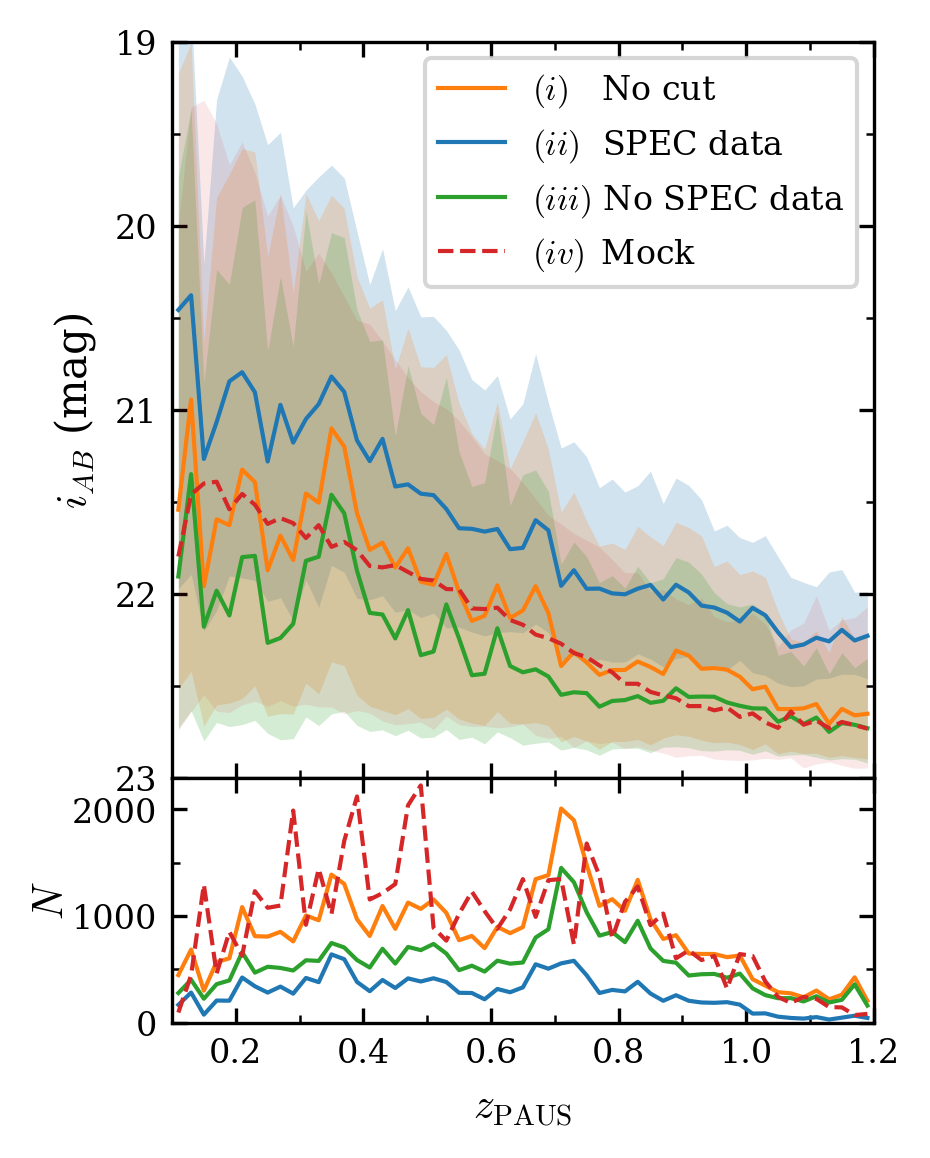

In [46]:
data_sample = data.loc[pd.notna(data['zspec']) & (data['zspec']!=0)]

factor = latex_textwidth/72*0.5
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

fillalpha = 0.2

# ax = plt.subplot(331+i)
bins = []
bin_range = [0.1,1.2]
#     print(bin_range)

bin_increment = 0.02
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

mid_zbins = (temp_bins[1:]+temp_bins[:-1])/2
median_imag_LC_segments = []
counts_segs = []

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
    
medians, lbs, ubs = [],[],[]

data_pairs = [[data_sample['zb'],data_sample['i_auto']],[data['zb'],data['i_auto']],[data.loc[data['zspec']==0,'zb'],data.loc[data['zspec']==0,'i_auto']]]
labels = [r'$\mathit{(ii)}$  SPEC data',r'$\mathit{(i)}$   No cut',r'$\mathit{(iii)}$ No SPEC data']

for ind,pair in enumerate(data_pairs):
    medians,bins,digs = scipy.stats.binned_statistic(pair[0],pair[1],'median',temp_bins)
    uniques,counts = np.unique(digs,return_counts=True)
    
    lbs = scipy.stats.binned_statistic(pair[0],pair[1],lb68,bins)[0]
    ubs = scipy.stats.binned_statistic(pair[0],pair[1],ub68,bins)[0]
    
    ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=fillalpha,zorder=1,color=colors[ind],linewidth=0)
    
    ax1.plot(mid_zbins,medians,'-',color=colors[ind],label=labels[ind],zorder=10)
    try: ax2.plot(mid_zbins,counts[1:],color=colors[ind])
    except Exception:
        try: ax2.plot(mid_zbins,counts[1:-1],color=colors[ind])
        except Exception: pass
        continue

        
mag_cut = 23
LC_zs = np.array(LC_DATA_CORE['Data/z_cos'])
LC_imags = np.array(LC_DATA_PHOTOM['Data/appOio_tot_ext'])
LC_ras = np.array(LC_DATA_CORE['Data/ra'])
LC_decs = np.array(LC_DATA_CORE['Data/dec'])


mask = (LC_imags < mag_cut) & (abs(np.mean(LC_ras) - LC_ras) <= 1) & (abs(np.mean(LC_decs) - LC_decs) <= 0.5)
# LC_zs, LC_imags = LC_zs[mask], LC_imags[mask]

print(mask.sum(),np.mean(LC_ras),np.mean(LC_decs))
print(LC_ras.min(),LC_ras.max(),LC_decs.min(),LC_decs.max())

median_imags_LC,bins, dig_L = scipy.stats.binned_statistic(LC_zs[mask],LC_imags[mask],'median',temp_bins)
unique, counts_LC = np.unique(dig_L,return_counts=True)

lb68_LC,a,b = scipy.stats.binned_statistic(LC_zs[mask],LC_imags[mask],lb68,temp_bins)
ub68_LC,a,b = scipy.stats.binned_statistic(LC_zs[mask],LC_imags[mask],ub68,temp_bins)

# RA_incs = range(129,142,2)
# DEC_incs = range(-2,4,1)
# RA_list, DEC_list = [], []

# for i in range(len(RA_incs)-1):
#     RA_list.append([RA_incs[i],RA_incs[i+1]])

# for i in range(len(DEC_incs)-1):
#     DEC_list.append([DEC_incs[i],DEC_incs[i+1]])
    
# for ra_bin in RA_list:
#     for dec_bin in DEC_list:
#         mask = (LC_ras > ra_bin[0]) & (LC_ras < ra_bin[1]) & (LC_decs > dec_bin[0]) & (LC_decs < dec_bin[1]) & (LC_imags < mag_cut) & (LC_zs <= 1.2)
#         zs_temp, imags_temp = LC_zs[mask], LC_imags[mask]
#         medians, bins, digs =  scipy.stats.binned_statistic(zs_temp,imags_temp,'median',temp_bins)
        
#         median_imag_LC_segments.append(medians)
#         unique, counts = np.unique(digs,return_counts=True)
#         counts_segs.append(counts)


# counts_segs_ = counts_segs[0]
# counts_segs_ = np.concatenate((counts_segs_[None,:],counts_segs[1][None,:]),axis=0)

# for i in range(len(counts_segs)-2):
#     counts_segs_ = np.concatenate((counts_segs_,counts_segs[i+2][None,:]),axis=0)


# median_imag_LC_segments = np.array(median_imag_LC_segments)
# lb68_ = np.percentile(median_imag_LC_segments,95.5,axis=0)
# ub68_ = np.percentile(median_imag_LC_segments,100-95.5,axis=0)

# lb_counts = np.percentile(counts_segs_[:,1:],50-34.1,axis=0)
# ub_counts = np.percentile(counts_segs_[:,1:],50+34.1,axis=0)

ax1.plot(mid_zbins,median_imags_LC,color=colors[3],linestyle='--',label=r'$(iv)\,$ Mock',zorder=20)
# ax1.fill_between(mid_zbins,lb68_,ub68_,alpha=fillalpha,color=colors[3],zorder=5)
ax1.fill_between(mid_zbins,lb68_LC,ub68_LC,alpha=0.1,color=colors[3],zorder=5,linewidth=0)
ax2.plot(mid_zbins,counts_LC[1:-1],'--',color=colors[3],label='Mean across Mock segments')
# ax2.plot(mid_zbins,counts_segs_[:,1:].mean(axis=0),'--',color=colors[3],label='Mean across Mock segments')
# ax2.fill_between(mid_zbins,lb_counts,ub_counts,alpha=fillalpha,color=colors[3],zorder=1,label='$\omega_{68}$')


ax2.set_xlabel('$z_\mathrm{PAUS}$')
ax1.set_xlim([0.1,1.2])
ax2.set_ylim([0,2300])
ax1.set_ylim([19,23])
ax1.set_ylabel('$i_{AB}$ (mag)')
ax2.set_ylabel('$N$',labelpad=0)
ax1.yaxis.set_major_locator(tick.MultipleLocator(1))
ax2.xaxis.set_minor_locator(tick.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(tick.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(tick.AutoMinorLocator(2))

redshiftdip = 0.35
# ax1.axvline(redshiftdip,linestyle='--',color='blue',zorder=1,label='zb = {}'.format(redshiftdip))
# ax2.axvline(redshiftdip,linestyle='--',color='blue',zorder=1)
ax1.invert_yaxis()

# ax1.legend(fontsize=8)
# print(counts_segs_[:,1:].mean(axis=0),'\n',counts_P[1:])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(left=0.16)

handles,labels = ax1.get_legend_handles_labels()
handles,labels = [handles[1],handles[0],handles[2],handles[3]],[labels[1],labels[0],labels[2],labels[3]]

ax1.legend(handles,labels)

custom_SAVEFIG('MEDIAN_i_BAND_z')
plt.show()


In [22]:

# matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'

In [12]:
matplotlib.rcParams

/home/andrew/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

## SED

Save figure? (y/n)y
Figure is saved as 20190422_225302_SED.png


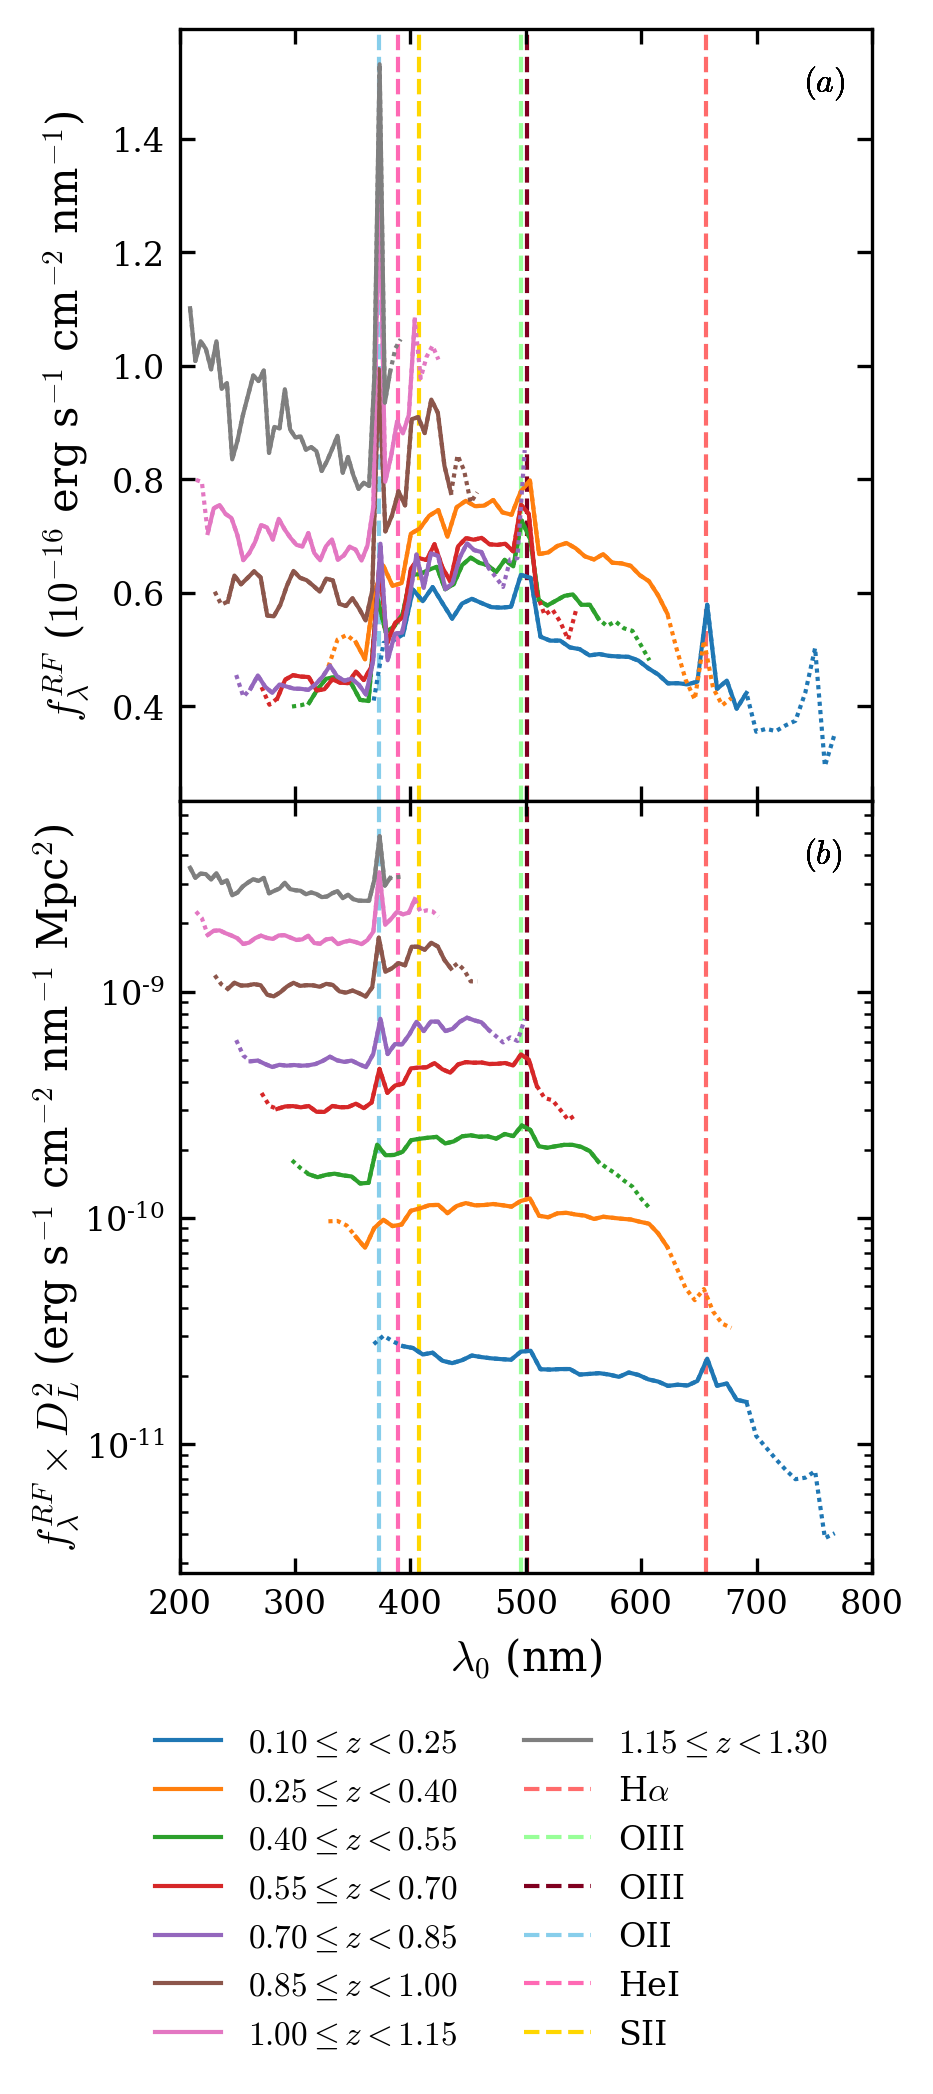

In [49]:
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 
data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]

lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
# calculate luminosity distance for all objects

luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
z_photos = data_sample['zb']


FWHM = 13 # nm
c = 299792458e9 # nm s^-1
cgs_factor = 10**(-(26+48.6)/2.5)
# defining FWHM of filter, PAUS flux -> cgs unit conversion factor, speed of light


bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
# temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
# for ind,i in enumerate(temp_bins[:-1]):
#     bins.append([temp_bins[ind],temp_bins[ind+1]]) 

bins = np.arange(bin_range[0],bin_range[1]+bin_increment, bin_increment)
# setting up redshift bin intervals

factor = latex_textwidth/72 * 0.5

fig, axs = plt.subplots(2,1,figsize=(factor,factor*2.2),dpi=300,sharex=True)
# ax1 = plt.subplot(121)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# converting waveegnths to restframe

bandwidtharray = np.linspace(8.5,4,len(bins))
# width of bins

for plot in (0,1):

    all_means = []
    percent_data = []
    percent_data_x = []

    for ind,z_bin in enumerate(bins[:-1]):

        truth_table = (z_photos >= bins[ind]) & (z_photos <= bins[ind+1])
        n_objects = truth_table.sum()
        lamb_sample = band_obsframe[truth_table].flatten()
        flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
        # selecting relevant data based on redshift range

        z_samp = np.repeat(z_photos[truth_table],40)
        # selecting sample of zb

        lum_dist_sample = luminosity_distances[truth_table].flatten()
        # selecting only relevant LDs

        band_width = bandwidtharray[ind]
        band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
        # calculating wl bins

        N_objects = band_obsframe[truth_table].shape[0]
        digitized = np.digitize(lamb_sample,band_bins)
        # calculating where objects fall in wl bins

        # binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])) for i in range(1,len(band_bins))]
        # ^ what has been used so far
        
        if plot == 0:
            binned_means = [np.nanmedian(flux_sample[digitized == i]*(1+z_samp[digitized == i])*cgs_factor*c/(lamb_sample[digitized==i])**2) for i in range(1,len(band_bins))]
        # f_RF = f/(1+z) * cgs_factor * c/lambda^2
        elif plot == 1:
            binned_means = [np.nanmedian(flux_sample[digitized == i]*(1+z_samp[digitized == i])*cgs_factor*c/(lamb_sample[digitized==i])**2 * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]

        binobject_count = np.bincount(digitized)
        percent_data.append(binobject_count/n_objects) 
        eighty_percent_mask = binobject_count/n_objects >= 0.75
        eighty_percent_mask = eighty_percent_mask[1:-1]    

        all_means.append(binned_means) #flux(in AB mags)/band wl


        line = axs[plot].plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
                 zorder=10,linestyle='--', dashes = (1,1)) #flux(in AB mags)/500 band wl
        # plot median of redshift bin of all wl bins as dashed line

        plottingbins = (band_bins[1:]+band_bins[:-1])/2
        percent_data_x.append(plottingbins)
        masked_data_x = np.ma.masked_where(~eighty_percent_mask,plottingbins)
        masked_data_y = np.ma.masked_where(~eighty_percent_mask,binned_means)
        axs[plot].plot(masked_data_x,masked_data_y,\
                 label="${:.02f} \leq z < {:.02f}$".format(bins[ind],bins[ind+1]),\
                 zorder=10,linestyle='-', color=line[0].get_color())                                 

        if plot == 0: axs[plot].text(0.9,0.92,'$(a)$',fontsize=8,transform=axs[plot].transAxes)
        else: axs[plot].text(0.9,0.92,'$(b)$',fontsize=8,transform=axs[plot].transAxes)


    emis_lines = [[656.28,r'H$\alpha$'],[496,r'OIII'],[500.8,r'OIII'],[372.8,r"OII"],[388.9,r'HeI'],[407.2,r'SII']]
    colours = ['#ff6b6b','#98ff98','#800020','skyblue','hotpink','gold','black','white']
    for i,line in enumerate(emis_lines):
    #     random_ints = np.random.randint(256,size=3)
    # color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
        axs[plot].axvline(line[0],color=colours[i],linestyle='--',zorder=1,label=line[1])
    # plotting emission lines with set colours


axs[1].set_xlabel(r'$\lambda_0$ (nm)')
axs[0].set_ylabel(r'$f^{RF}_{\lambda}$ ($10^{-16}$ erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$)')
axs[0].yaxis.offsetText.set_visible(False)
axs[1].set_ylabel(r'$f^{RF}_{\lambda} \times D_L^2$ (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$ Mpc$^2$)')
# plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,frameon=False)
# fixed_aspect_ratio(1)
# custom_SAVEFIG(filetag='SED_LD')

axs[1].set_yscale('log')
# plt.ylim([0,2.5e6])
axs[1].set_xlim([200,800])
# plt.tight_layout()

fig.subplots_adjust(hspace=0,bottom=0.2,left=0.17)
axs[0].yaxis.labelpad = 5
axs[1].yaxis.labelpad = 0.8

axs[1].legend(loc='upper center', bbox_to_anchor=(0.45, -0.16), ncol=2,frameon=False)
# plt.legend()
# plt.tight_layout()
plt.subplots_adjust(top=0.99,bottom=0.25)
custom_SAVEFIG(filetag='SED')
plt.show()



/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


Mock region
RA: 134.0-136.0
Dec: -0.0-1.0
Save figure? (y/n)y
Figure is saved as 20190422_222037_CDF_COMBINED_PAUS_MOCK.png


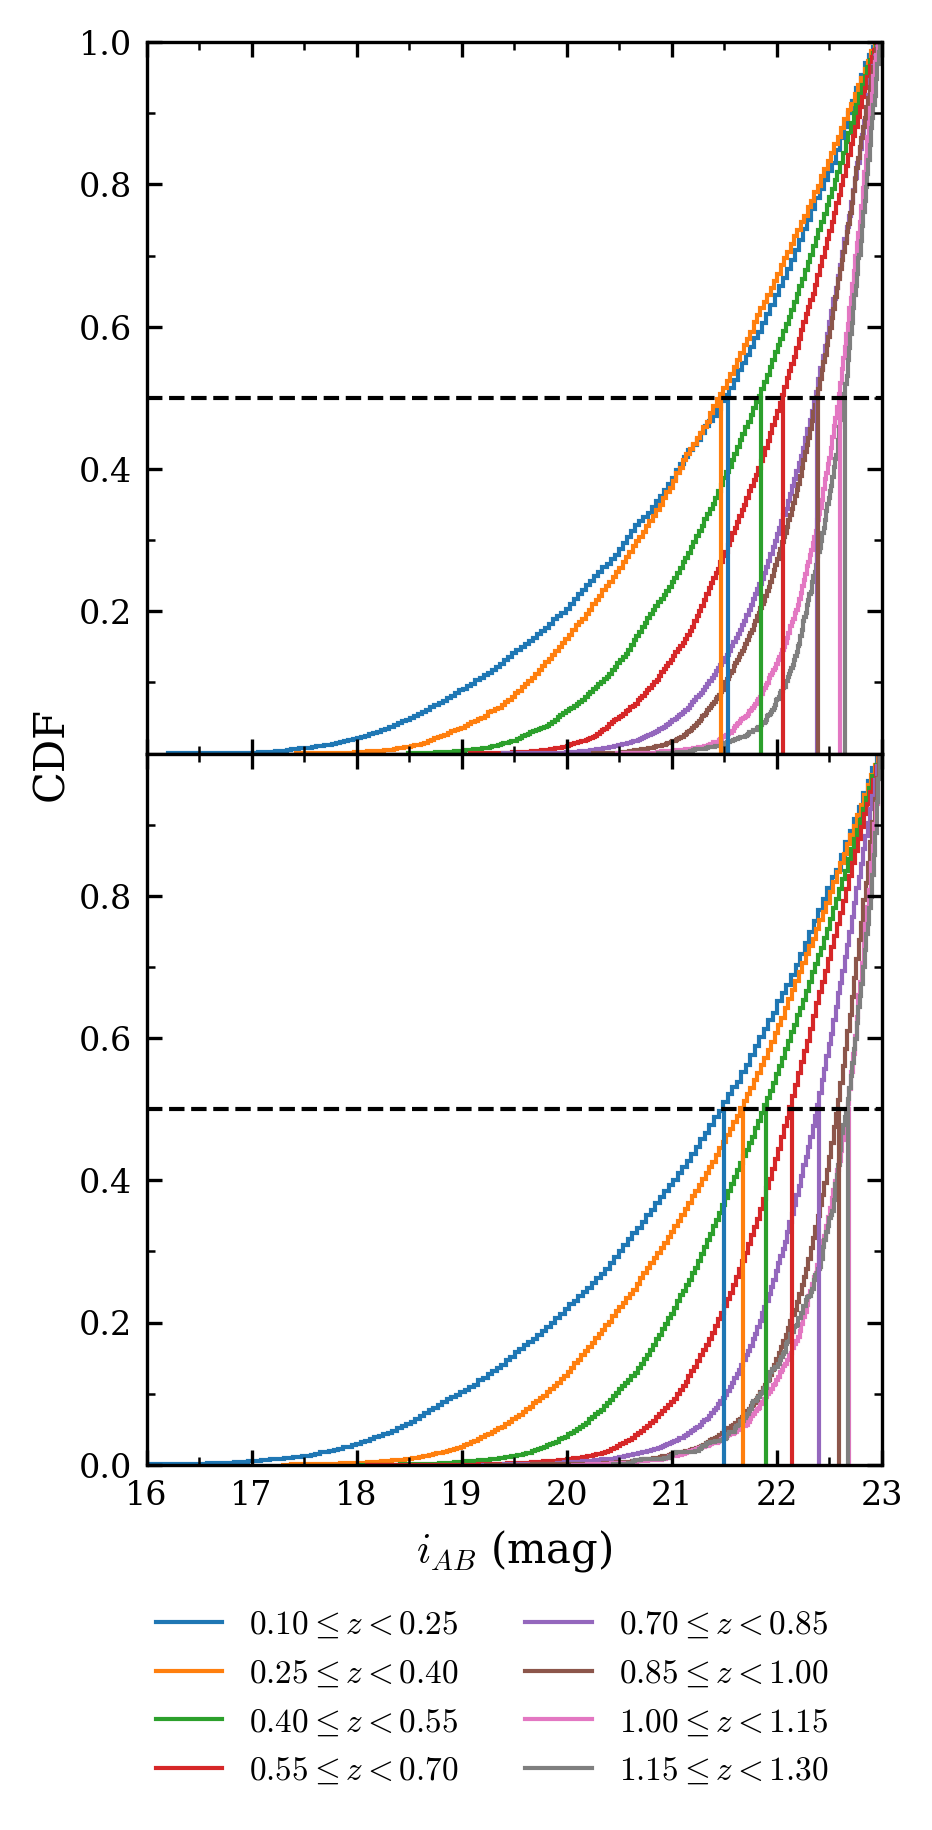

In [38]:
factor = latex_textwidth/72*0.5
fig = plt.figure(figsize=(1*factor,2*factor),dpi=300)
ax1 = plt.subplot(211)
zbins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    zbins.append([temp_bins[ind],temp_bins[ind+1]])
    
medians_a,medians_b = [], []

increments = np.linspace(90,150,len(bins))
for ind,z_bin in enumerate(zbins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)
    
#     lamb_sample = band_obsframe[truth_table].flatten()
    
    iband_mags = data_sample.loc[truth_table,'i_auto']
    N_objects = iband_mags.size
    median = np.median(iband_mags)
    bins = np.append(np.linspace(iband_mags.min(),iband_mags.max(),175), [np.inf])
#     digitized = np.digitize(lamb_sample,band_bins)
#     binned_means = [np.nanmedian(iband_mags[digitized == i]) for i in range(1,len(band_bins))]
    hist = plt.hist(iband_mags,bins,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
#     plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
#                 label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='Med = {:4.2f}'.format(median))
    medians_a.append(median)

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
# plt.xlabel('$i$ band apparent magnitude (mag)')
# plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
# plt.legend(fontsize=8)
# custom_SAVEFIG('PAUS_CDF')
# plt.show()
# locs, labels = plt.xticks()
plt.yticks(plt.yticks()[0][1:])
# plt.gca().set_xticklabels([])
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(212,sharex=ax1)

imags = np.array(LC_DATA_CORE['Data/appMio_tot_ext'])
zs = np.array(LC_DATA_CORE['Data/z_obs'])
LC_ras = np.array(LC_DATA_CORE['Data/ra'])
LC_decs = np.array(LC_DATA_CORE['Data/dec'])

mask = (imags<23) & (LC_ras < np.median(LC_ras)+1) & (LC_ras > np.median(LC_ras)-1) & (LC_decs < np.median(LC_decs)+0.5) & (LC_decs > np.median(LC_decs)-0.5)
print("Mock region\nRA: {:.1f}-{:.1f}\nDec: {:.1f}-{:.1f}".format(np.median(LC_ras)-1,np.median(LC_ras)+1,np.median(LC_decs)-0.5,np.median(LC_decs)+0.5))
zs = zs[mask]
imags = imags[mask]



# print(zs.min(),zs.max())

# plt.figure(figsize=(1*factor,1*factor),dpi=300)

# bins = []
# bin_range = [0.1,1.2]
# bin_increment = 0.15
# temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
# for ind,i in enumerate(temp_bins[:-1]):
#     bins.append([temp_bins[ind],temp_bins[ind+1]])

for ind,z_bin in enumerate(zbins):
    
    truth_table = (zs >= z_bin[0]) & (zs <= z_bin[1]) 
    
    iband_mags = imags[truth_table]
    N_objects = iband_mags.size
    median = np.median(iband_mags)
    
    bins = np.append(np.linspace(iband_mags.min(),iband_mags.max(),175), [np.inf])
    
    hist = plt.hist(iband_mags,bins,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
#     plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
#                 label='{:.02f} < z < {:.02f}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],median))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label="${:.02f} \leq z < {:.02f}$".format(z_bin[0],z_bin[1]))
    medians_b.append(median)

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
plt.xlabel('$i_{AB}$ (mag)')
# plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
# plt.legend(loc='upper left',fontsize=8)

# custom_SAVEFIG('MOCK_SUBSECTION_CDF')
fig.subplots_adjust(hspace=0,top=0.95,bottom=0.2)
plt.text(-0.13,0,'CDF',horizontalalignment='center',\
          verticalalignment='center', transform=ax1.transAxes,rotation='vertical',fontsize=10)

plt.yticks(plt.yticks()[0][:-1])
plt.xlim(16,23)

ax1.yaxis.set_minor_locator(tick.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(tick.AutoMinorLocator(2))
ax2.xaxis.set_minor_locator(tick.AutoMinorLocator(2))

median_arr = np.array([medians_a,medians_b])

plt.legend(loc='upper center', bbox_to_anchor=(0.47, -0.16), ncol=2,frameon=False)

custom_SAVEFIG('CDF_COMBINED_PAUS_MOCK')


plt.show()

In [9]:
datas_pd = np.append(np.array(zbins),median_arr.T,axis=1)
table = pd.DataFrame(datas_pd,columns=[r'$z_0$',r'$z_1$',r'$i_{AB,\text{ PAUS}}$',r'$i_{AB,\text{ Mock}}$'])


In [10]:
for i in table.values: print("${:.2f} < z < {:.2f}$ & ${:.2f}$ & ${:.2f}$ \\\\".format(i[0],i[1],i[2],i[3]))


$0.10 < z < 0.25$ & $21.54$ & $21.50$ \\
$0.25 < z < 0.40$ & $21.47$ & $21.68$ \\
$0.40 < z < 0.55$ & $21.85$ & $21.90$ \\
$0.55 < z < 0.70$ & $22.07$ & $22.15$ \\
$0.70 < z < 0.85$ & $22.38$ & $22.40$ \\
$0.85 < z < 1.00$ & $22.40$ & $22.59$ \\
$1.00 < z < 1.15$ & $22.60$ & $22.69$ \\
$1.15 < z < 1.30$ & $22.65$ & $22.68$ \\


# Single Reg comparison (Section 4.2)

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

Save figure? (y/n)y
Figure is saved as 20190422_231017_SINGLE_COMPARISON.png


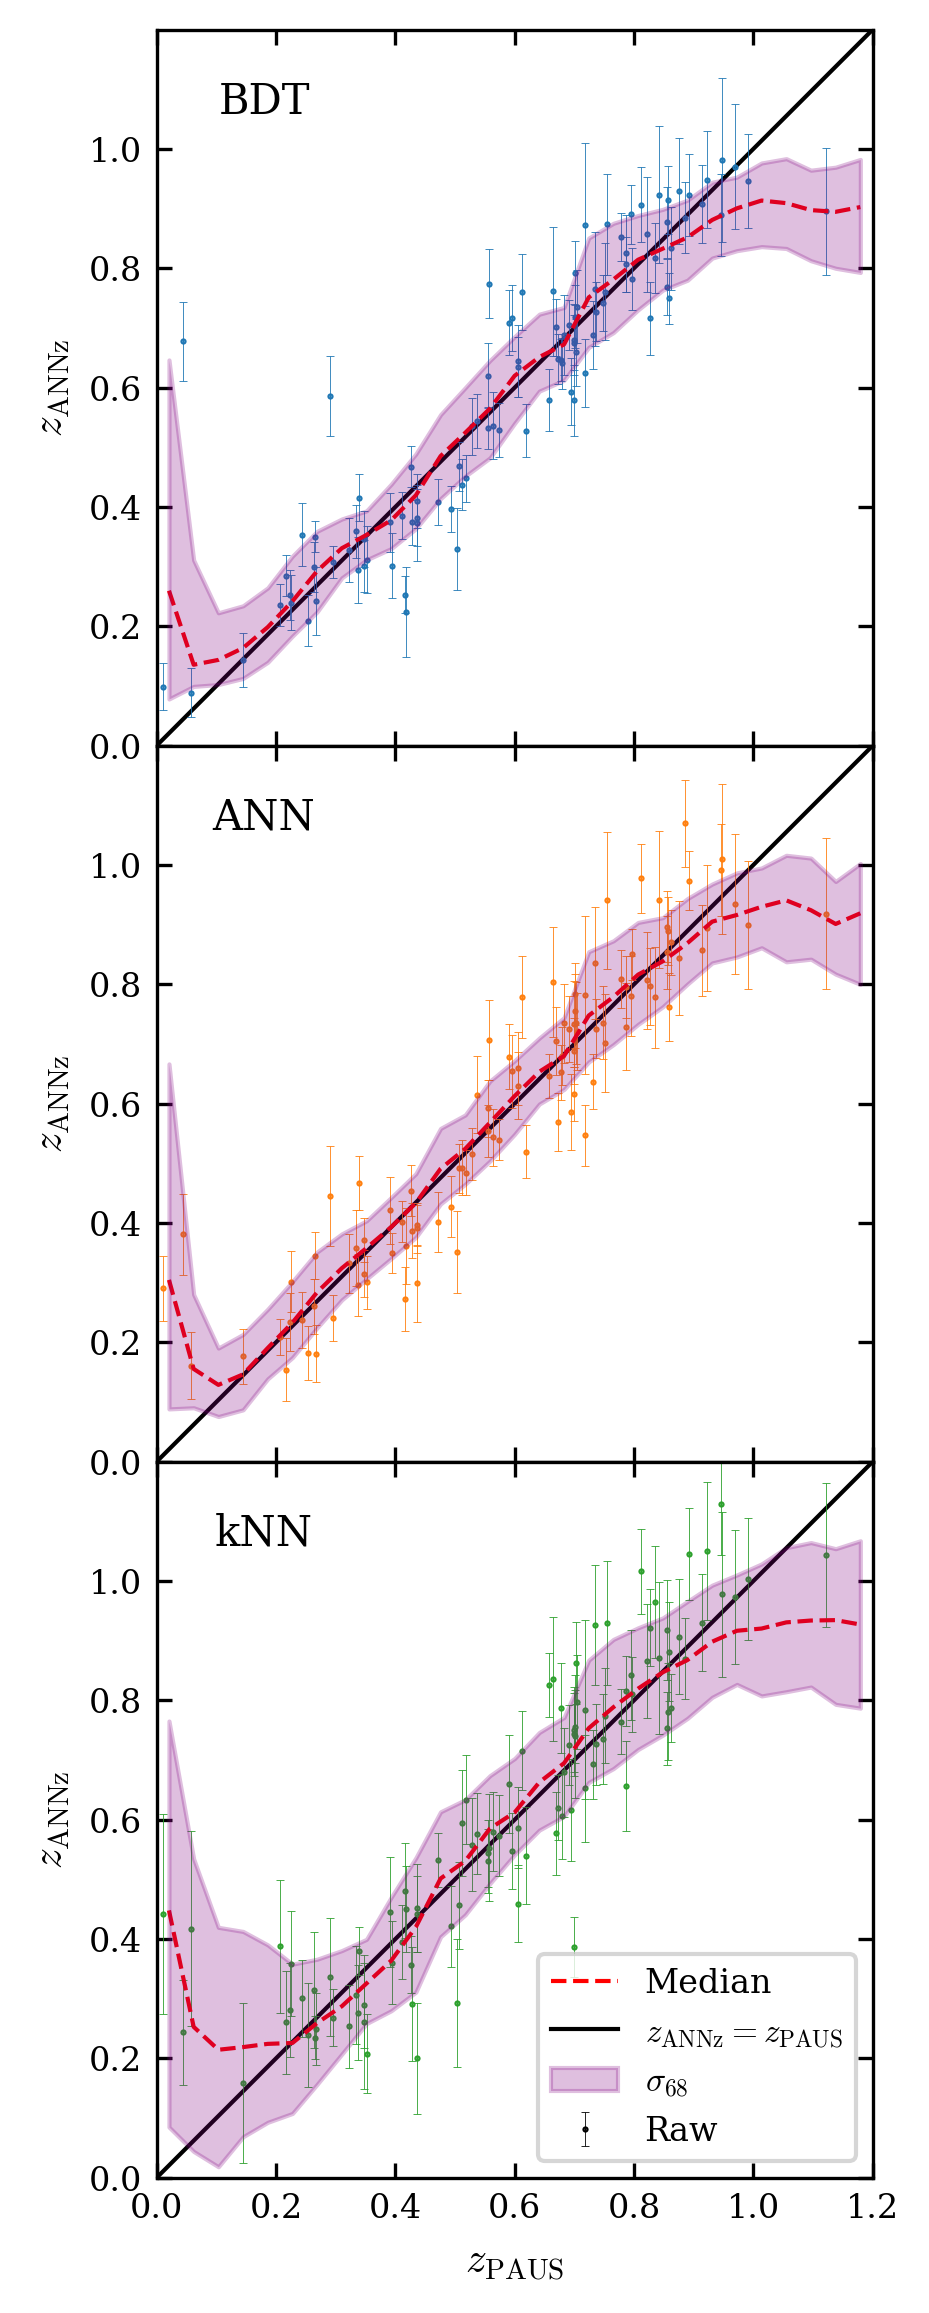

In [56]:

MLMs = ['PAUS_single2','PAUS_single3','PAUS_single4']
MLM_names = {'PAUS_single2':'BDT',
             'PAUS_single3':'ANN',
             'PAUS_single4':'kNN'}
stats = []
data_objs = []

for mlm in MLMs:
    tmp_df = pd.read_csv("../../ML runs/{}/ANNZ_singleReg_0000.csv".format(mlm),header=0)
    out1, out2 = compute_error_stats_paus(tmp_df)
    stats.append(out1)
    data_objs.append(out2)
    
column_labels = ["mean error","st. dev","68th percentile","percentage outliers"]
knn_stats = pd.DataFrame(stats,columns=column_labels,index=MLM_names.values())
    
N_points = 100
indices = np.random.choice(data_objs[0][0].size,N_points,replace=False)
factor = latex_textwidth/72*0.5
fig, axs = plt.subplots(len(MLMs),1,figsize=(factor,factor*len(MLMs)),dpi=300,sharex=True)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# axs = [ax1,ax2]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# colors = ['blue','orange','green']

for ind,objs in enumerate(data_objs):
    min_bin, max_bin, N_bin = 0.0,1.2,30
    bins = np.linspace(min_bin, max_bin, N_bin)
    
    meds,edge,counts = scipy.stats.binned_statistic(objs[2],objs[0],'median',bins=bins)
    lbs = scipy.stats.binned_statistic(objs[2],objs[0],lb68,bins)[0]
    ubs = scipy.stats.binned_statistic(objs[2],objs[0],ub68,bins)[0]

    axs[ind].text(0.15,0.9,'{}'.format(MLM_names[MLMs[ind]]),horizontalalignment='center',\
        verticalalignment='center', transform=axs[ind].transAxes,fontsize=10)
    
    axs[ind].errorbar(objs[2][indices],objs[0][indices],yerr=objs[1][indices]\
                 ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,zorder=2,color=colors[ind])
    axs[ind].plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
    
    axs[ind].fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=10,label=r'$\sigma_{68}$',color='purple')
    
    axs[ind].plot([0,1.2],[0,1.2],'k-',label=r'$z_\mathrm{ANNz}=z_\mathrm{PAUS}$',zorder=1)

    axs[ind].set_ylabel(r'$z_\mathrm{ANNz}$')
    
    axs[ind].set_xlim(0.0,1.2)
    axs[ind].set_ylim(0.0,1.2)
    
    axs[ind].set_aspect('equal')
    
    axs[ind].set_yticks(axs[ind].get_yticks()[:-1])

axs[-1].errorbar(-1,-1,yerr=1,fmt='o',label='Raw',color='black',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2)
axs[-1].set_xlabel(r'$z_\mathrm{PAUS}$')
axs[-1].legend(loc='lower right')
fig.subplots_adjust(hspace=0)
custom_SAVEFIG('SINGLE_COMPARISON')
plt.show()

In [12]:
knn_stats.style.format({column_labels[0]: "{:.2E}", column_labels[1]: '{:.3f}', column_labels[2]: '{:.3f}', column_labels[3]: '{:.2f}%'})
# knn_stats

,mean error,st. dev,68th percentile,percentage outliers
BDT,1.06E-03,0.073,0.050,3.22%
ANN,2.55E-03,0.069,0.046,2.58%
kNN,6.33E-03,0.104,0.070,8.60%


In [13]:
# plt.rcParams

# PAUS_advanced 7 (Section 4.3.1)

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Save figure? (y/n)y
Figure is saved as 20190422_233151_RAND_REG_COMPARISON.png


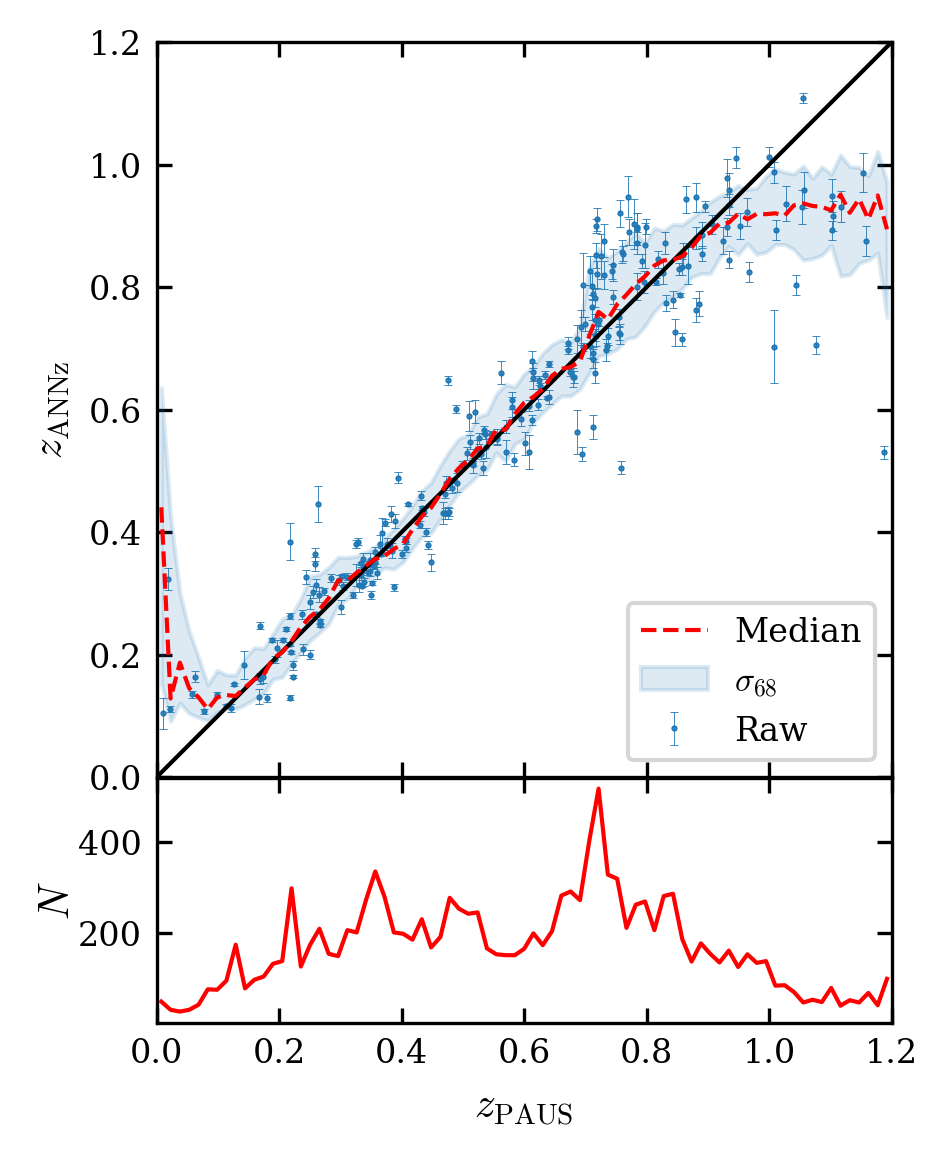

In [59]:

MLMs = ['PAUS_advanced7']
MLM_names = {'PAUS_advanced7':'BDT',
             }
stats = []
data_objs = []

for mlm in MLMs:
    tmp_df = pd.read_csv("../../ML runs/{}/ANNZ_randomReg_0000.csv".format(mlm),header=0)
    out1, out2 = compute_error_stats_paus(tmp_df)
    stats.append(out1)
    data_objs.append(out2)
    
column_labels = ["mean error","st. dev","68th percentile","percentage outliers"]
knn_stats = pd.DataFrame(stats,columns=column_labels,index=MLM_names.values())
    
N_points = 250
indices = np.random.choice(data_objs[0][0].size,N_points,replace=False)
factor = latex_textwidth/72*0.5
fig, axs = plt.subplots(2,1,figsize=(factor,1.37*factor),dpi=300,sharex=True\
                        ,gridspec_kw = {'height_ratios':[3, 1]})
# axs = [axs]
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# axs = [ax1,ax2]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# colors = ['blue','orange','green']

ind=0
for inda,objs in enumerate(data_objs):
    min_bin, max_bin, N_bin = 0.0,1.2,80
    bins = np.linspace(min_bin, max_bin, N_bin)
    
    meds,edge,counts = scipy.stats.binned_statistic(objs[2],objs[0],'median',bins=bins)
    lbs = scipy.stats.binned_statistic(objs[2],objs[0],lb68,bins)[0]
    ubs = scipy.stats.binned_statistic(objs[2],objs[0],ub68,bins)[0]

#     axs[ind].text(0.15,0.9,'{}'.format(MLM_names[MLMs[ind]]),horizontalalignment='center',\
#         verticalalignment='center', transform=axs[ind].transAxes,fontsize=10)
    
    axs[ind].errorbar(objs[2][indices],objs[0][indices],yerr=objs[1][indices]\
                 ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw',zorder=1,color=colors[inda])
    axs[ind].plot((bins[:-1]+bins[1:])/2,meds,'--',color='red',\
                  label='Median',zorder=10,linewidth=1)
    
    axs[ind].fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,\
                          color=colors[inda],label=r'$\sigma_{68}$',\
                          linestyle='-')
    
    axs[ind].plot([0,1.2],[0,1.2],'k-',zorder=4)

    axs[ind].set_ylabel(r'$z_\mathrm{ANNz}$')
    
#     axs[ind].set_xlim(0.0,1.2)
    axs[ind].set_ylim(0.0,1.2)
    
    axs[ind].set_aspect('equal')
    
#     axs[ind].set_yticks(axs[ind].get_yticks()[:-1])

unique, counted = np.unique(counts, return_counts=True)
axs[1].plot((bins[:-1]+bins[1:])/2,counted[:],'r-',zorder=5)

axs[-1].set_xlim(0.0,1.2)
axs[-1].set_xlabel(r'$z_\mathrm{PAUS}$')
axs[0].legend(loc='lower right')

axs[1].set_ylabel('$N$',labelpad=0)

fig.subplots_adjust(hspace=0)
custom_SAVEFIG('RAND_REG_COMPARISON')
plt.show()

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Save figure? (y/n)y
Figure is saved as 20190422_234414_ML_ERROR_RAND_REG_COMPA.png


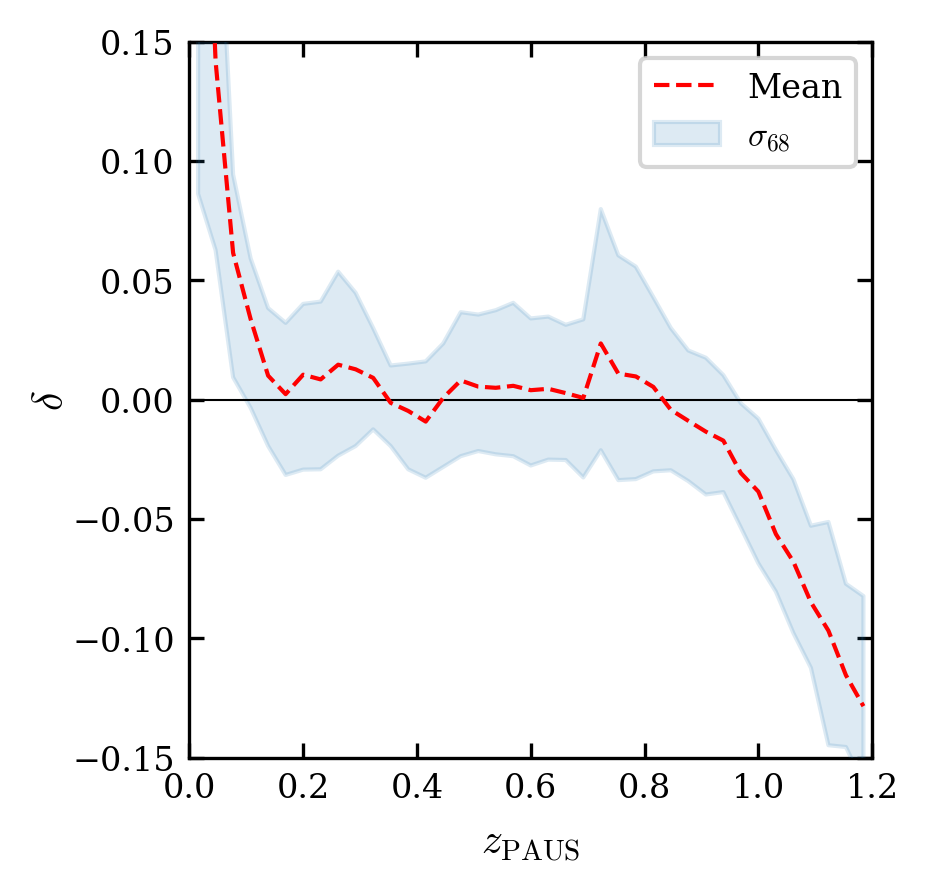

In [70]:
bins = np.linspace(0.0,1.2,40)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 600
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

for inda,objs in enumerate(data_objs):
    all_errors = normed_error(objs[0],objs[2])
    mask = (objs[2]<1.2) #& (abs(all_errors) < 0.2)
    
    z_paus = objs[2][mask]
    z_annz = objs[0][mask]
    error = normed_error(z_annz,z_paus)
    
    hist_Cut_val = 0.2
    
    
    mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

    lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
    ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)


    plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color=colors[0],label=r'$\sigma_{68}$')
#     hist = plt.hist2d(z_paus[abs(error)<hist_Cut_val],error[abs(error)<hist_Cut_val],[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
#     norm=matplotlib.colors.LogNorm()
    plt.plot((bins[1:]+bins[:-1])/2,mean,'--',color='red',zorder=10,label='Mean')




plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$',labelpad=0)
plt.xlabel('$z_\mathrm{PAUS}$')

# plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.0,1.2)
plt.ylim(-0.15,0.15)

# plt.colorbar(hist[3])
plt.legend()
# plt.tight_layout()
# plt.gca().xaxis.labelpad = 1
# plt.gca().yaxis.labelpad = 0
plt.subplots_adjust(left=0.18)
custom_SAVEFIG('ML_ERROR_RAND_REG_COMPA')
plt.show()

# PAUS_advance9 (Section 4.3.1)

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Save figure? (y/n)


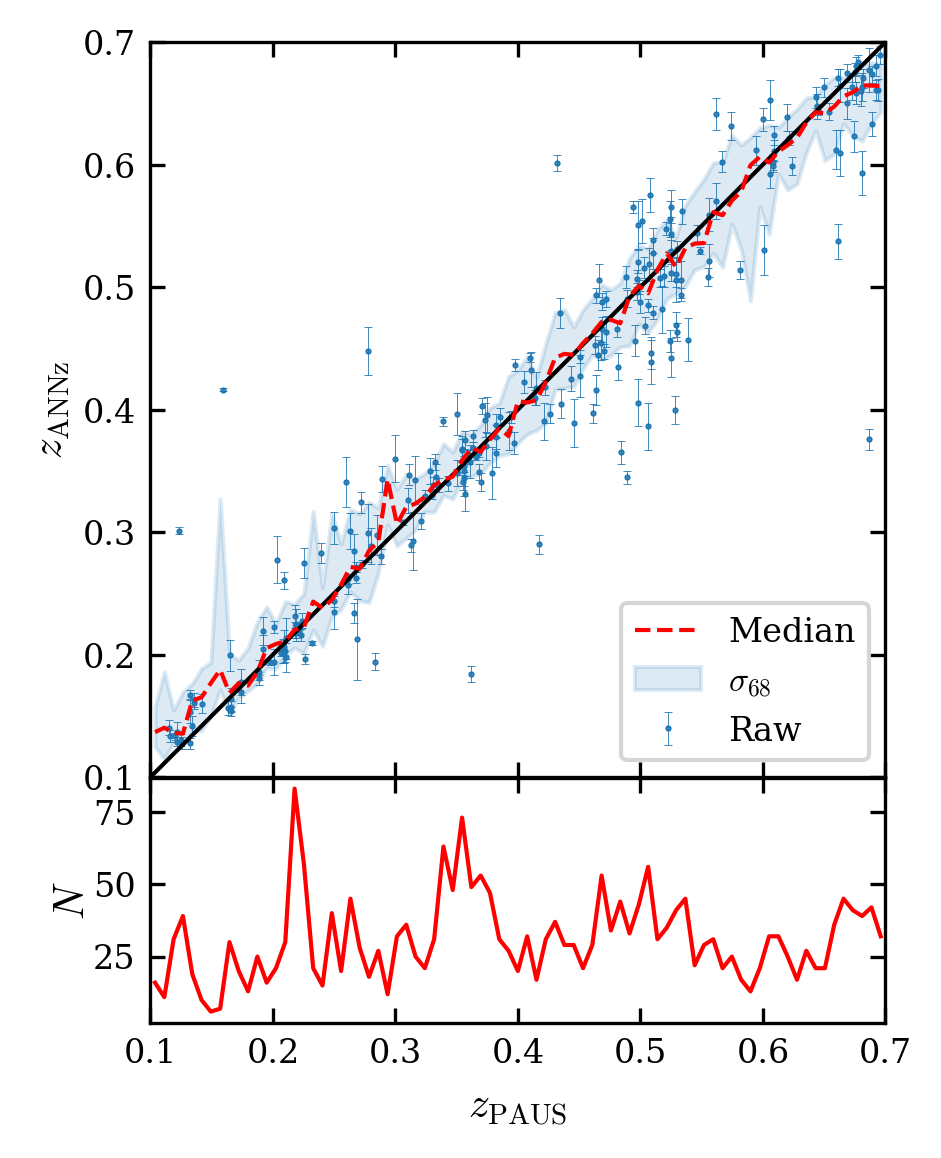

In [79]:

MLMs = ['PAUS_advanced9']
MLM_names = {'PAUS_advanced7':'BDT',
             }
stats = []
data_objs = []

for mlm in MLMs:
    tmp_df = pd.read_csv("../../ML runs/{}/ANNZ_randomReg_0000.csv".format(mlm),header=0)
    out1, out2 = compute_error_stats_paus(tmp_df)
    stats.append(out1)
    data_objs.append(out2)
    
column_labels = ["mean error","st. dev","68th percentile","percentage outliers"]
knn_stats = pd.DataFrame(stats,columns=column_labels,index=MLM_names.values())
    
N_points = 250
indices = np.random.choice(data_objs[0][0].size,N_points,replace=False)
factor = latex_textwidth/72*0.5
fig, axs = plt.subplots(2,1,figsize=(factor,1.37*factor),dpi=300,sharex=True\
                        ,gridspec_kw = {'height_ratios':[3, 1]})
# axs = [axs]
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# axs = [ax1,ax2]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# colors = ['blue','orange','green']

ind=0
for inda,objs in enumerate(data_objs):
    min_bin, max_bin, N_bin = 0.1,0.7,80
    bins = np.linspace(min_bin, max_bin, N_bin)
    
    meds,edge,counts = scipy.stats.binned_statistic(objs[2],objs[0],'median',bins=bins)
    lbs = scipy.stats.binned_statistic(objs[2],objs[0],lb68,bins)[0]
    ubs = scipy.stats.binned_statistic(objs[2],objs[0],ub68,bins)[0]

#     axs[ind].text(0.15,0.9,'{}'.format(MLM_names[MLMs[ind]]),horizontalalignment='center',\
#         verticalalignment='center', transform=axs[ind].transAxes,fontsize=10)
    
    axs[ind].errorbar(objs[2][indices],objs[0][indices],yerr=objs[1][indices]\
                 ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw',zorder=1,color=colors[inda])
    axs[ind].plot((bins[:-1]+bins[1:])/2,meds,'--',color='red',\
                  label='Median',zorder=10,linewidth=1)
    
    axs[ind].fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,\
                          color=colors[inda],label=r'$\sigma_{68}$',\
                          linestyle='-')
    
    axs[ind].plot([0,1.2],[0,1.2],'k-',zorder=4)

    axs[ind].set_ylabel(r'$z_\mathrm{ANNz}$',labelpad=2.5)
    
#     axs[ind].set_xlim(0.0,1.2)
    axs[ind].set_ylim(0.1,0.7)
    
    axs[ind].set_aspect('equal')
    
#     axs[ind].set_yticks(axs[ind].get_yticks()[:-1])

unique, counted = np.unique(counts, return_counts=True)
axs[1].plot((bins[:-1]+bins[1:])/2,counted[:],'r-',zorder=5)

axs[-1].set_xlim(0.1,0.7)
axs[-1].set_xlabel(r'$z_\mathrm{PAUS}$')
axs[0].legend(loc='lower right')

axs[1].set_ylabel('$N$',labelpad=0)

fig.subplots_adjust(hspace=0)
custom_SAVEFIG('PAUS_advanced9_zz')
plt.show()

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Save figure? (y/n)


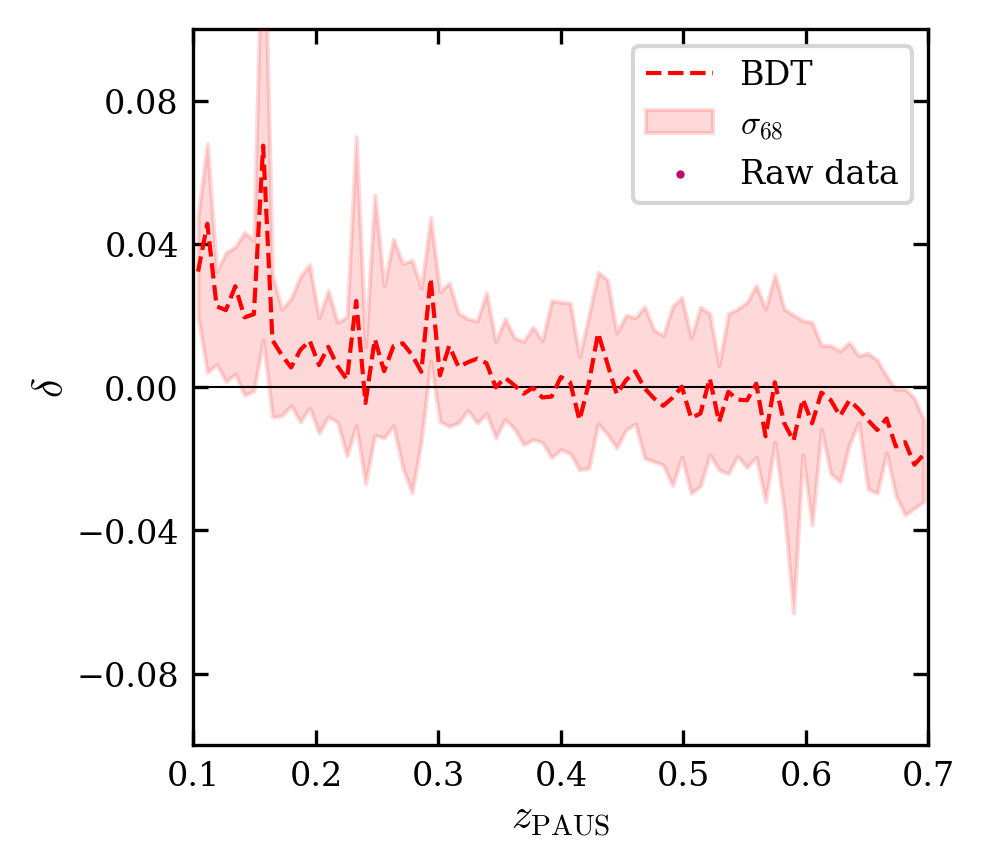

In [80]:
# bins = np.linspace(0.0,1.2,40)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 300
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

for inda,objs in enumerate(data_objs):
    all_errors = normed_error(objs[0],objs[2])
    mask = (objs[2]<1.2) #& (abs(all_errors) < 0.2)
    
    z_paus = objs[2][mask]
    z_annz = objs[0][mask]
    error = normed_error(z_annz,z_paus)
    
    hist_Cut_val = 0.1
    
    
    mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

    lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
    ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)


    plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color='red',label=r'$\sigma_{68}$')
#     hist = plt.hist2d(z_paus[abs(error)<hist_Cut_val],error[abs(error)<hist_Cut_val],[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
#     norm=matplotlib.colors.LogNorm()
    plt.plot((bins[1:]+bins[:-1])/2,mean,'--',color='red',zorder=10,label='BDT')




plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_\mathrm{PAUS}$')

plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.1,0.7)
plt.ylim(-0.1,0.1)

# plt.colorbar(hist[3])
plt.legend()
# plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
plt.gca().yaxis.set_major_locator(tick.MultipleLocator(0.04))
custom_SAVEFIG('PAUS_advanced9_error')
plt.show()

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Save figure? (y/n)y
Figure is saved as 20190423_000134_ML_ERROR_RAND_REG_COMPA.png


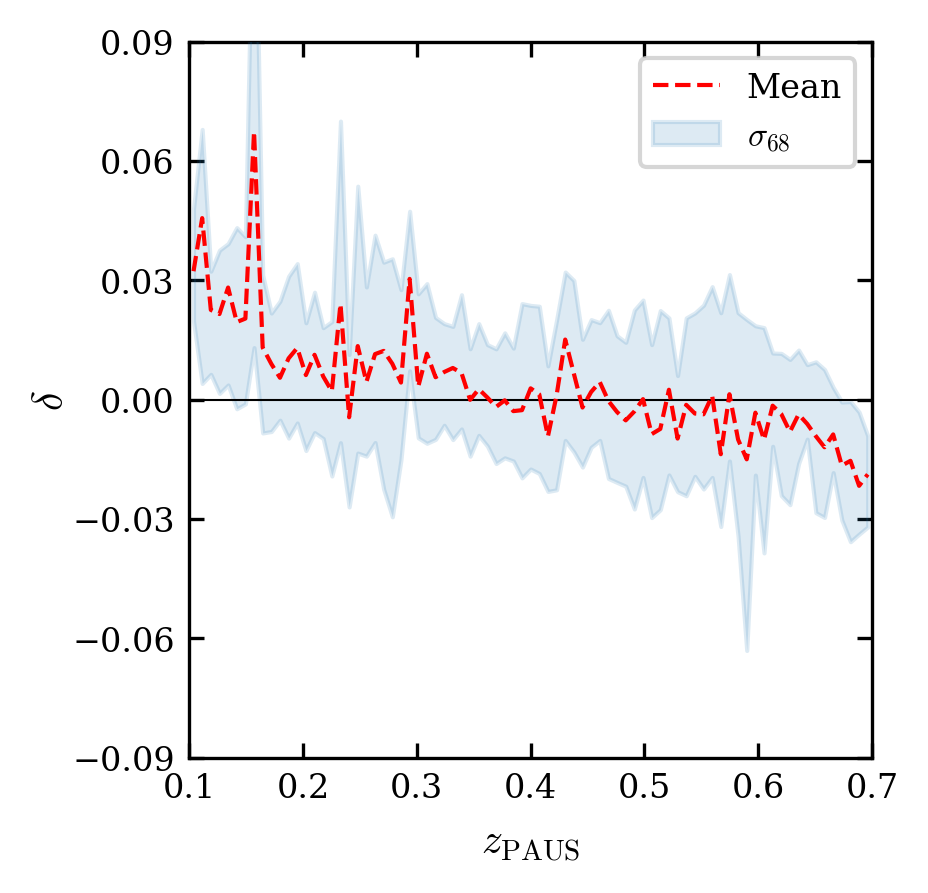

In [85]:
# bins = np.linspace(0.0,1.2,40)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 600
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

for inda,objs in enumerate(data_objs):
    all_errors = normed_error(objs[0],objs[2])
    mask = (objs[2]<1.2) #& (abs(all_errors) < 0.2)
    
    z_paus = objs[2][mask]
    z_annz = objs[0][mask]
    error = normed_error(z_annz,z_paus)
    
    hist_Cut_val = 0.2
    
    
    mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

    lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
    ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)


    plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color=colors[0],label=r'$\sigma_{68}$')
#     hist = plt.hist2d(z_paus[abs(error)<hist_Cut_val],error[abs(error)<hist_Cut_val],[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
#     norm=matplotlib.colors.LogNorm()
    plt.plot((bins[1:]+bins[:-1])/2,mean,'--',color='red',zorder=10,label='Mean')




plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$',labelpad=0)
plt.xlabel('$z_\mathrm{PAUS}$')

# plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.1,0.7)
plt.ylim(-0.09,0.09)

# plt.colorbar(hist[3])
plt.legend()
# plt.tight_layout()
# plt.gca().xaxis.labelpad = 1
# plt.gca().yaxis.labelpad = 0
plt.subplots_adjust(left=0.18)
plt.gca().yaxis.set_major_locator(tick.MultipleLocator(0.03))
custom_SAVEFIG('ML_ERROR_RAND_REG_COMPA')
plt.show()

In [ ]:
knn_stats.style.format({column_labels[0]: "{:.2E}", column_labels[1]: '{:.3f}', column_labels[2]: '{:.3f}', column_labels[3]: '{:.2f}%'})

# n MLM comparison (Section 4.3.2)

In [87]:
MLM_data_list = []
MLM_data_cut = []
read_ordera = [15,16,6,18,7,19,8,20,9,21,17,22,11]#,12,13,14]
read_orderb = [16,6,7,8,9]
for i in read_ordera:
    MLM_data_list.append(pd.read_csv('../../ML runs/SPEC_advanced{}/ANNZ_randomReg_0000.csv'.format(i),header=0))

for i in read_orderb:
    MLM_data_cut.append(pd.read_csv('../../ML runs/SPEC_advanced{}/ANNZ_randomReg_0001_cut.csv'.format(i),header=0))

In [88]:
stats = []
errors_obj = []

stats_cut = []
errors_obj_cut = []

for frame in MLM_data_list:
    tmp_stats = compute_error_stats_spec(frame)
    stats.append(tmp_stats[0])
    errors_obj.append(np.array(tmp_stats[1]))

for frame in MLM_data_cut:
    tmp_stats = compute_error_stats_spec(frame)
    stats_cut.append(tmp_stats[0])
    errors_obj_cut.append(np.array(tmp_stats[1]))

In [89]:
nMLM = [5,10,20,30,40,50,60,70,80,90,100,110,125]
column_labels = ["mean error","st. dev","68th percentile","percentage outliers"]

results = pd.DataFrame(stats,index=nMLM,columns=["mean error","st. dev","68th percentile","percentage outliers"])
results_cut = pd.DataFrame(stats_cut,index=[10,20,40,60,80],columns=["mean error","st. dev","68th percentile","percentage outliers"])

results_cut
# results_cut.style.format({column_labels[0]: "{:.2E}", column_labels[1]: '{:.3f}', column_labels[2]: '{:.3f}', column_labels[3]: '{:.2f}%'})

,mean error,st. dev,68th percentile,percentage outliers
10,0.007901,0.077645,0.051192,5.107527
20,0.007206,0.077259,0.049829,5.152330
40,0.007790,0.078110,0.051472,5.465950
60,0.007427,0.076933,0.050683,4.928315
80,0.007730,0.077306,0.050734,5.421147


In [90]:
# results
results.style.format({column_labels[0]: "{:.2E}", column_labels[1]: '{:.4f}', column_labels[2]: '{:.3f}', column_labels[3]: '{:.2f}%'})

,mean error,st. dev,68th percentile,percentage outliers
5,7.36E-03,0.0770,0.051,5.02%
10,7.90E-03,0.0776,0.051,5.11%
20,7.21E-03,0.0773,0.050,5.15%
30,7.36E-03,0.0769,0.051,5.24%
40,7.79E-03,0.0781,0.051,5.47%
50,6.94E-03,0.0773,0.051,5.06%
60,7.43E-03,0.0769,0.051,4.93%
70,6.80E-03,0.0763,0.050,5.06%
80,7.73E-03,0.0773,0.051,5.42%
90,7.55E-03,0.0772,0.050,5.29%


Save figure? (y/n)y
Figure is saved as 20190423_002927_nMLM_COMPARRISON.png


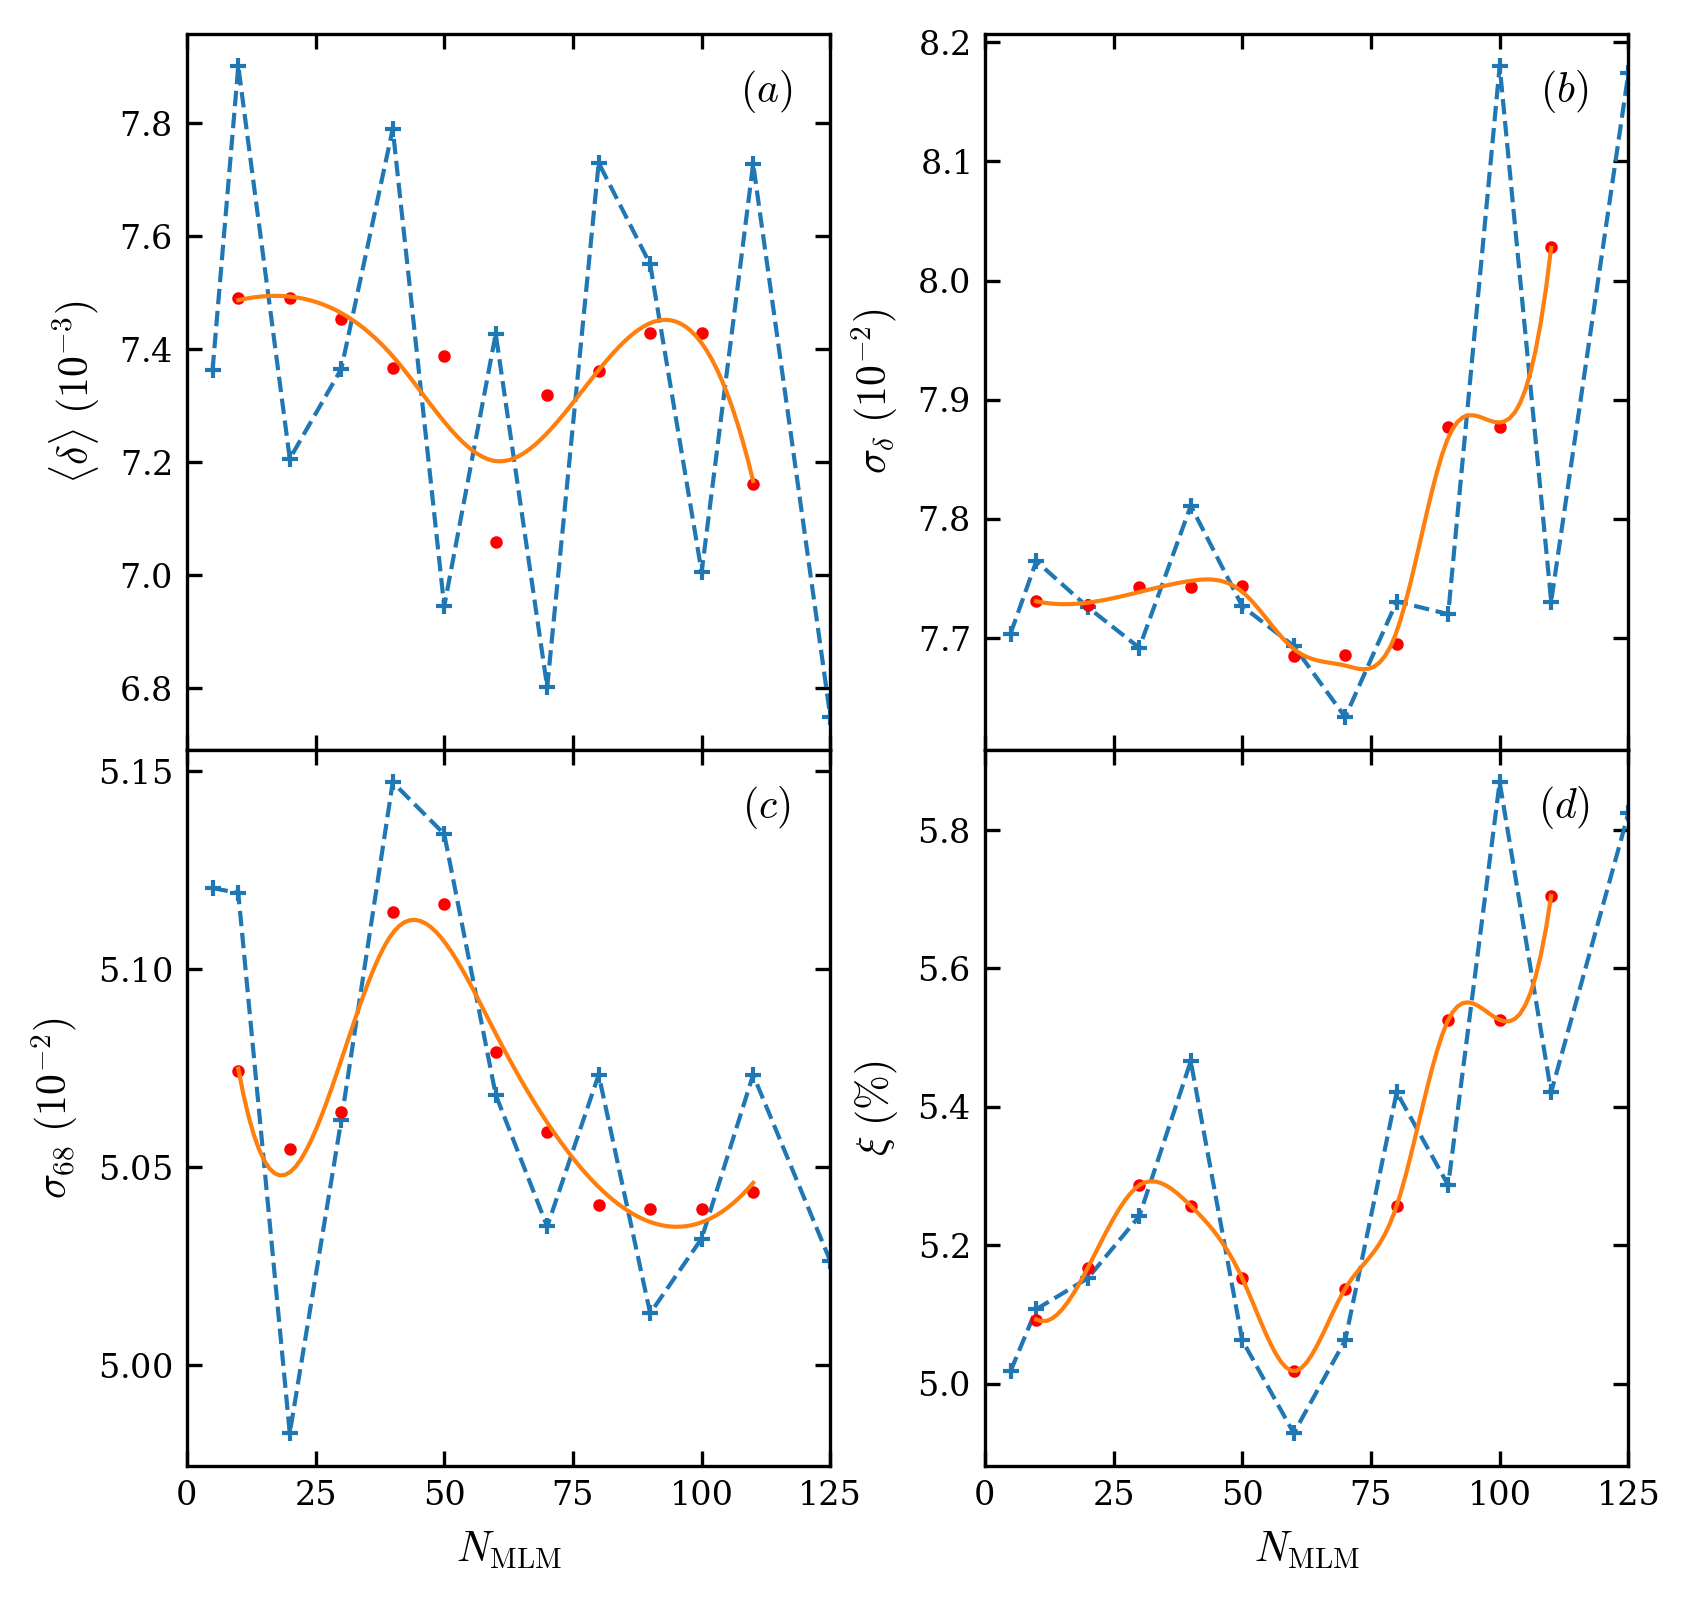

In [97]:
factor = latex_textwidth/72 * 0.5

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,figsize=(factor*2,factor*2),dpi=300)

axs = [ax1,ax2,ax3,ax4]
letters = [r'$(a)$',r'$(b)$',r'$(c)$',r'$(d)$']

for ind,ax in enumerate(axs):

    ax.plot(results.index.values,results.iloc[:,ind],'--+',ms=4)
    ax.plot(results.index.values[:-1],results.rolling(3).mean().iloc[1:,ind],'ro',ms=2)
    
    
    
    tck = scipy.interpolate.splrep(results.index.values[1:-1],results.rolling(3).mean().iloc[2:,ind],k=3,s=0.00000004)
#     print(tck)
    xs_ = np.linspace(results.index.values[1],results.index.values[-2],100)
    f = scipy.interpolate.interp1d(results.index.values[1:-1],results.rolling(3).mean().iloc[2:,ind],kind='cubic',fill_value='extrapolate')
    ys1_ = f(xs_)
    ys2_ = scipy.interpolate.splev(xs_,tck)
#     ax.plot(xs_,ys1_,'g-')
    ax.plot(xs_,ys2_,'-')
    ax.text(0.9,0.92,letters[ind],transform=ax.transAxes,horizontalalignment='center',
            verticalalignment='center')
    
#     print(xs_,ys_)
#     print(results.index.values[1:-1],results.rolling(3).mean().iloc[:-1,ind])


# ax2.plot(results.index.values,results.iloc[:,1],'--+',ms=4)
# ax2.plot(results.index.values[:-1],results.rolling(3).mean().iloc[1:,1],'r--',ms=4)
# ax3.plot(results.index.values,results.iloc[:,2],'--+',ms=4)
# ax4.plot(results.index.values,results.iloc[:,3],'--+',ms=4)

ax1.set_ylabel(r"$\langle \delta \rangle\ (10^{-3})$")
ax2.set_ylabel(r"$\sigma_\delta\ (10^{-2})$")
ax3.set_ylabel(r"$\sigma_{68}\ (10^{-2})$")
ax3.yaxis.set_major_locator(tick.MultipleLocator(0.5e-3))
ax3.set_xlabel(r"$N_\mathrm{MLM}$")
ax4.set_xlabel(r"$N_\mathrm{MLM}$")
ax4.set_ylabel(r"$\xi\ (\%)$")
ax4.set_xlim([0,125])

# plt.tight_layout()

for ax in axs:
    ax.ticklabel_format(axis='y',style='sci',useMathText=True,scilimits=(0,0))
    ax.yaxis.offsetText.set_visible(False)

plt.subplots_adjust(hspace=0.0,left=0.14,wspace=0.24)
plt.subplot

custom_SAVEFIG("nMLM_COMPARRISON")
plt.show()

# Random Regression, one algorithm type only (Section 5.1)

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

Save figure? (y/n)


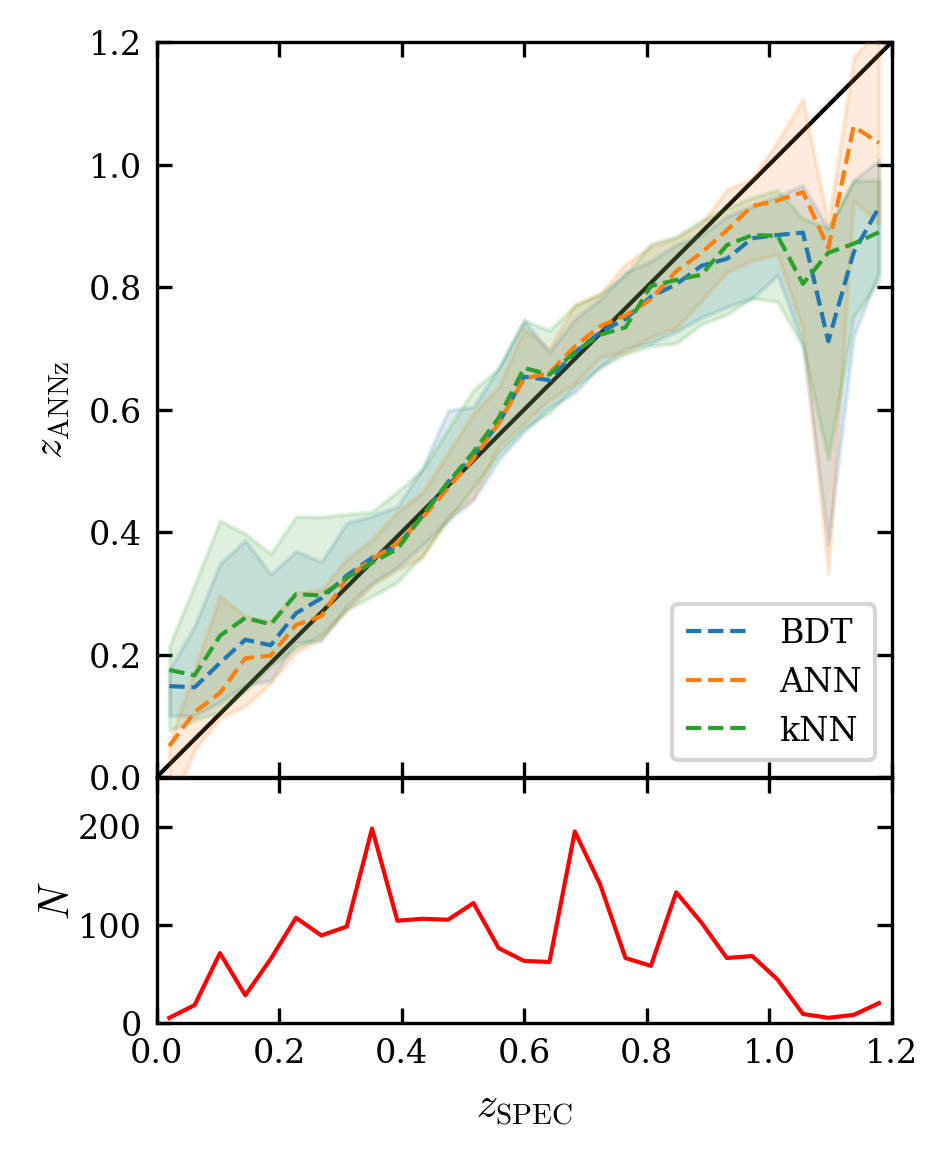

In [14]:

# MLMs = ['SPEC_advanced19','SPEC_advanced23','SPEC_advanced5']
MLMs = ['SPEC_advanced19','SPEC_advanced23','SPEC_advanced5']
MLM_names = {'SPEC_advanced19':'BDT',
             'SPEC_advanced23':'ANN',
            'SPEC_advanced5':'kNN'}
stats = []
data_objs = []

for mlm in MLMs:
    tmp_df = pd.read_csv("../../ML runs/{}/ANNZ_randomReg_0000.csv".format(mlm),header=0)
    out1, out2 = compute_error_stats_spec(tmp_df)
    stats.append(out1)
    data_objs.append(out2)
    
column_labels = ["mean error","st. dev","68th percentile","percentage outliers"]
stats = pd.DataFrame(stats,columns=column_labels,index=MLM_names.values())
stats_cut = 
    
N_points = 100
indices = np.random.choice(data_objs[0][0].size,N_points,replace=False)
factor = latex_textwidth/72*0.5
fig, axs = plt.subplots(2,1,figsize=(factor,1.37*factor),dpi=300,sharex=True\
                        ,gridspec_kw = {'height_ratios':[3, 1]})
# axs = [axs]
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# axs = [ax1,ax2]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# colors = ['blue','orange','green']

medians = []

ind=0
for inda,objs in enumerate(data_objs):
    min_bin, max_bin, N_bin = 0.0,1.2,30
    bins = np.linspace(min_bin, max_bin, N_bin)
    
    meds,edge,counts = scipy.stats.binned_statistic(objs[2],objs[0],'median',bins=bins)
    lbs = scipy.stats.binned_statistic(objs[2],objs[0],lb68,bins)[0]
    ubs = scipy.stats.binned_statistic(objs[2],objs[0],ub68,bins)[0]

#     axs[ind].text(0.15,0.9,'{}'.format(MLM_names[MLMs[ind]]),horizontalalignment='center',\
#         verticalalignment='center', transform=axs[ind].transAxes,fontsize=10)
    
#     axs[ind].errorbar(objs[2][indices],objs[0][indices],yerr=objs[1][indices]\
#                  ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw',zorder=1,color=colors[inda])
    axs[ind].plot((bins[:-1]+bins[1:])/2,meds,'--',color=colors[inda],\
                  label='{}'.format(MLM_names[MLMs[inda]]),zorder=10,linewidth=1)
    
    axs[ind].fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=5,\
                          color=colors[inda],\
                          linestyle='-')
    
    medians.append(meds)

    axs[ind].set_ylabel(r'$z_\mathrm{ANNz}$')
    
#     axs[ind].set_xlim(0.0,1.2)
    axs[ind].set_ylim(0.0,1.2)
    
    axs[ind].set_aspect('equal')
    
#     axs[ind].set_yticks(axs[ind].get_yticks()[:-1])

axs[ind].plot([0,1.2],[0,1.2],'k-',zorder=1)

unique, counted = np.unique(counts, return_counts=True)
axs[1].plot((bins[:-1]+bins[1:])/2,counted[:],'r-',zorder=5)

axs[-1].set_xlim(0.0,1.2)
axs[-1].set_xlabel(r'$z_\mathrm{SPEC}$')
# axs[1].yaxis.la
axs[0].legend(loc='lower right')

axs[1].set_ylabel('$N$',labelpad=0.1)
axs[1].set_ylim((0,250))

fig.subplots_adjust(hspace=0)
custom_SAVEFIG('RAND_REG_COMPARISON')
plt.show()

In [15]:
# CHI^2 values



for ind,da in enumerate(data_objs):
#     print(data)
#     chis = chisq(da[0],da[1],da[2])
    chis2 = sumsqresid(medians[ind],(bins[1:]+bins[:-1])/2)
#     print(MLM_names[MLMs[ind]]+" X2_min = {:.3f}".format(chis/da[0].size))
    print(MLM_names[MLMs[ind]]+" SumSqResids = {:.3f}".format(chis2))

BDT SumSqResids = 0.399
ANN SumSqResids = 0.113
kNN SumSqResids = 0.392


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

Save figure? (y/n)


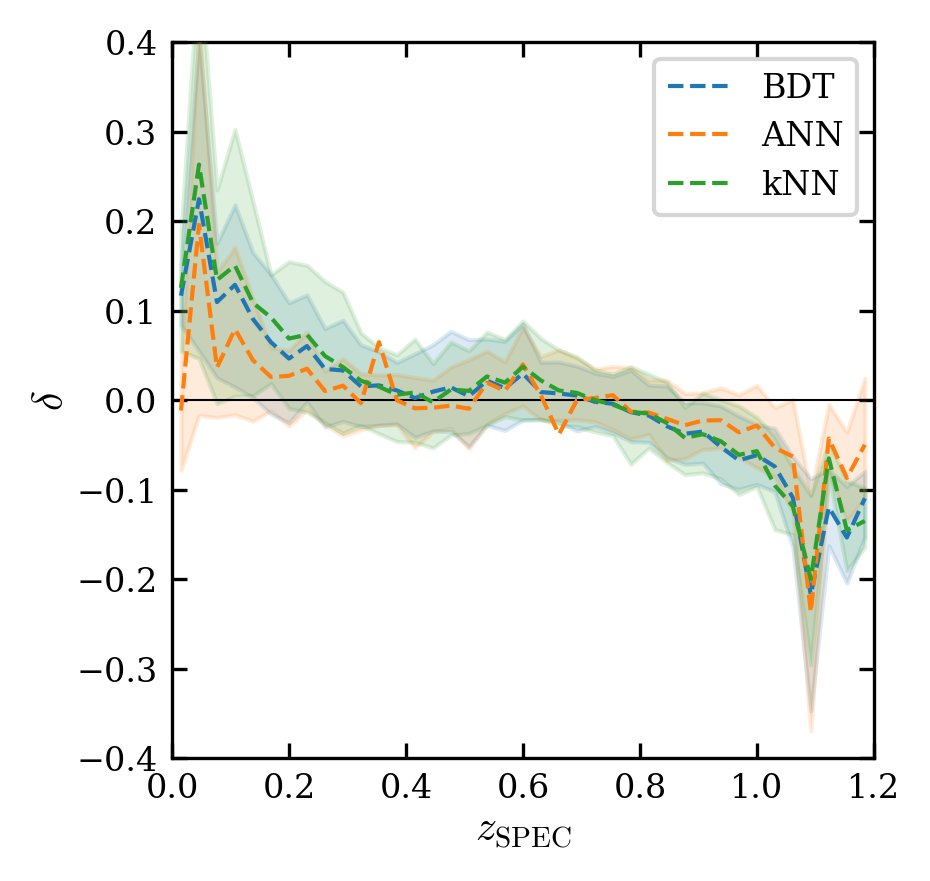

In [16]:
bins = np.linspace(0.0,1.2,40)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 350
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

means = []

for inda,objs in enumerate(data_objs):
    all_errors = normed_error(objs[0],objs[2])
    mask = (objs[2]<1.2) #& (abs(all_errors) < 0.5)
    
    z_paus = objs[2][mask]
    z_annz = objs[0][mask]
    error = normed_error(z_annz,z_paus)
    
    
    mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

    means.append(mean)
    lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
    ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)


    plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color=colors[inda])
#     hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
#     norm=matplotlib.colors.LogNorm()
    plt.plot((bins[1:]+bins[:-1])/2,mean,'--',color=colors[inda],zorder=10,label='{}'.format(MLM_names[MLMs[inda]]))




plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_\mathrm{SPEC}$')

# plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.0,1.2)
plt.ylim(-0.4,0.4)

# plt.colorbar(hist[3])
plt.legend()
# plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
plt.subplots_adjust(left=0.16)
custom_SAVEFIG('ML_ERROR_RAND_REG_COMPA')
plt.show()

In [17]:
for ind,mean in enumerate(means):

    chis2 = sumsqresid(means[ind],0)

    print(MLM_names[MLMs[ind]]+" SumSqResids = {:.3f}".format(chis2))

BDT SumSqResids = 0.245
ANN SumSqResids = 0.139
kNN SumSqResids = 0.284


In [18]:
knn_stats

,mean error,st. dev,68th percentile,percentage outliers
BDT,0.006945,0.077266,0.051341,5.062724
ANN,0.002911,0.234404,0.039555,3.853047
kNN,0.011192,0.085498,0.059810,7.258065


# Cumulative Frac error and cumulative sigma (Still section 5.1)

Save figure? (y/n)


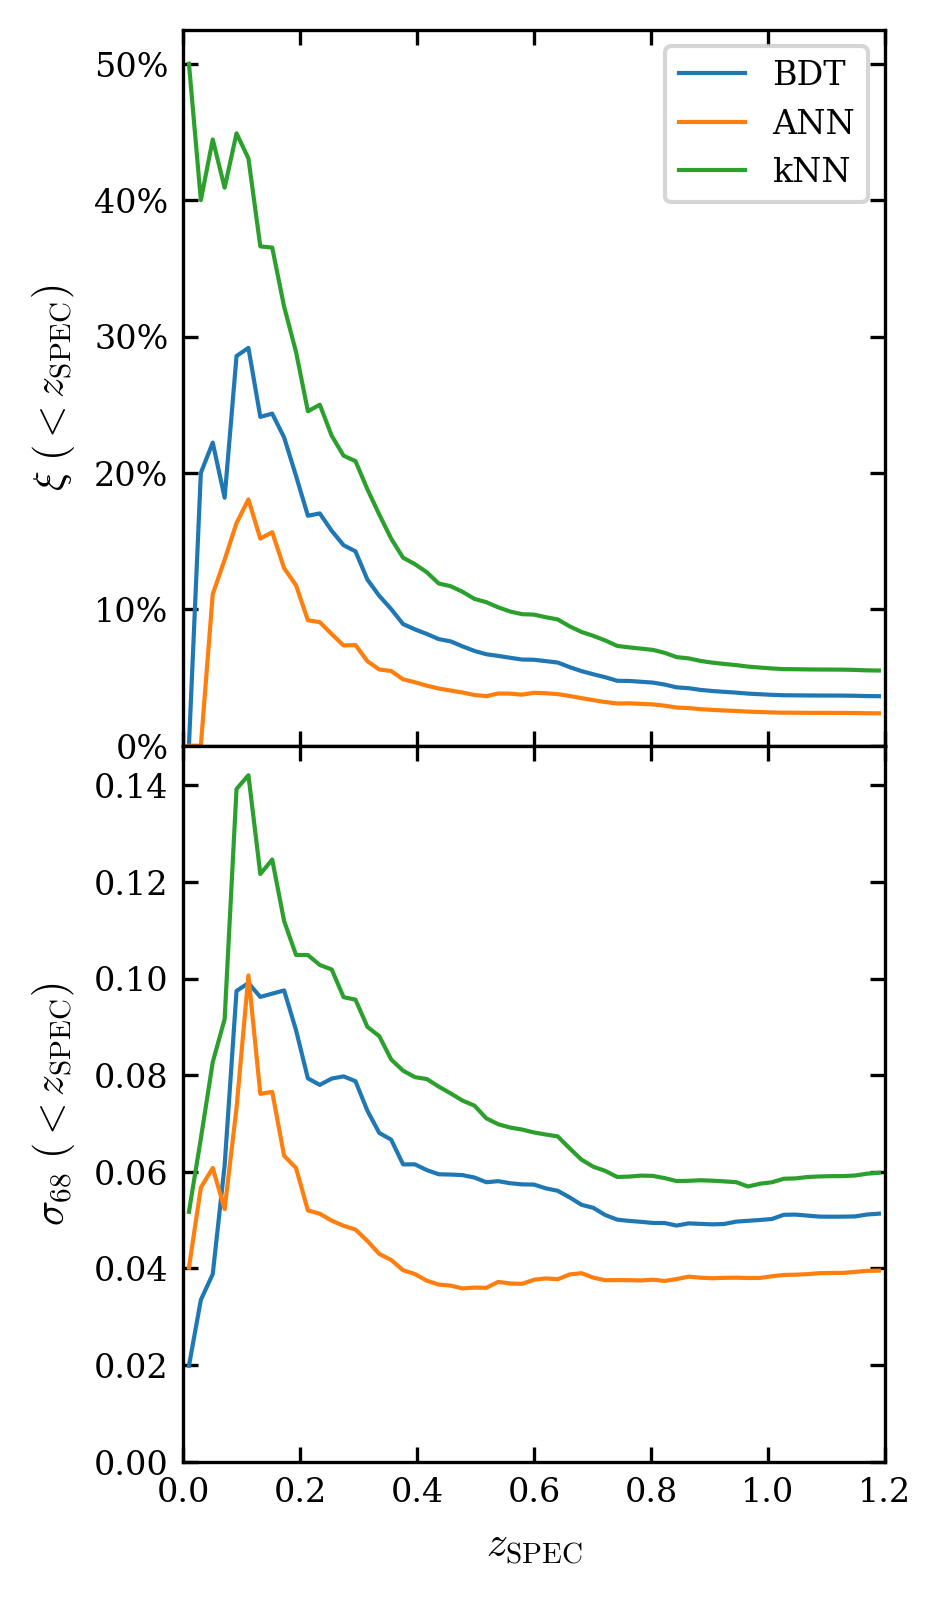

In [9]:
MLMs = ['SPEC_advanced19','SPEC_advanced23','SPEC_advanced5']
MLM_names = {'SPEC_advanced5':'kNN',
             'SPEC_advanced19':'BDT',
             'SPEC_advanced23':'ANN'}
stats = []
data_objs = []

for mlm in MLMs:
    tmp_df = pd.read_csv("../../ML runs/{}/ANNZ_randomReg_0000.csv".format(mlm),header=0)
    out1, out2 = compute_error_stats_spec(tmp_df)
    stats.append(out1)
    data_objs.append(out2)

zbins = np.linspace(0,1.2,60)


catoutliers, cumsigma = [], []
for objs in data_objs:
    tmp_catoutliers, tmp_cumsigma = [], []
    annz,annz_es,spec = objs
    for z in zbins[1:]:
        tmp_catoutliers.append( cumulative_caterrors(spec,annz,z) )
        tmp_cumsigma.append( cumulative_sigma68(spec,annz,z) )
    catoutliers.append(tmp_catoutliers) 
    cumsigma.append(tmp_cumsigma)

catoutliers = np.array(catoutliers)
cumsigma = np.array(cumsigma)

# print(catoutliers,cumsigma)

# cumsigma = []
# for objs in data_objs:
#     tmp_cumsigma = []
#     annz,annz_es,spec = objs
#     for z in zbins[1:]:
#         tmp_cumsigma.append( cumulative_sigma68(spec,annz,z) )
#     cumsigma.append(tmp_catoutliers)    

# cumsigma = np.array(cumsigma)


factor = latex_textwidth/72 * 0.5


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(factor,factor*2),dpi=300,sharex=True)

for ind,l in enumerate(catoutliers):
    ax1.plot((zbins[1:]+zbins[:-1])/2,l*100,linestyle='-',label='{}'.format(MLM_names[MLMs[ind]]))
    
# plt.xlim(0,1.2)
ax1.set_ylim(0,ax1.get_ylim()[1])
# plt.xlabel(r'$z_{SPEC}$')
ax1.set_ylabel(r'$\xi\ (<z_\mathrm{SPEC})$')


for l in cumsigma:
    ax2.plot((zbins[1:]+zbins[:-1])/2,l,linestyle='-')
    
ax2.set_xlim(0,1.2)
ax2.set_ylim(0,ax2.get_ylim()[1])
ax2.set_xlabel(r'$z_\mathrm{SPEC}$')
ax2.set_ylabel(r'$\sigma_{68}\ (<z_\mathrm{SPEC})$')
ax1.legend()

ax1.yaxis.set_major_formatter(tick.PercentFormatter(xmax=100))



plt.subplots_adjust(hspace=0,left=0.16)

custom_SAVEFIG('CUMULATIVE_ERROR_STATS_INDIV_ALGS')

plt.show()

## (Appendix A4)

Save figure? (y/n)y
Figure is saved as 20190423_213837_CUMULATIVE_SIGMA_DELTA_RANDREG_APPENDIX.png


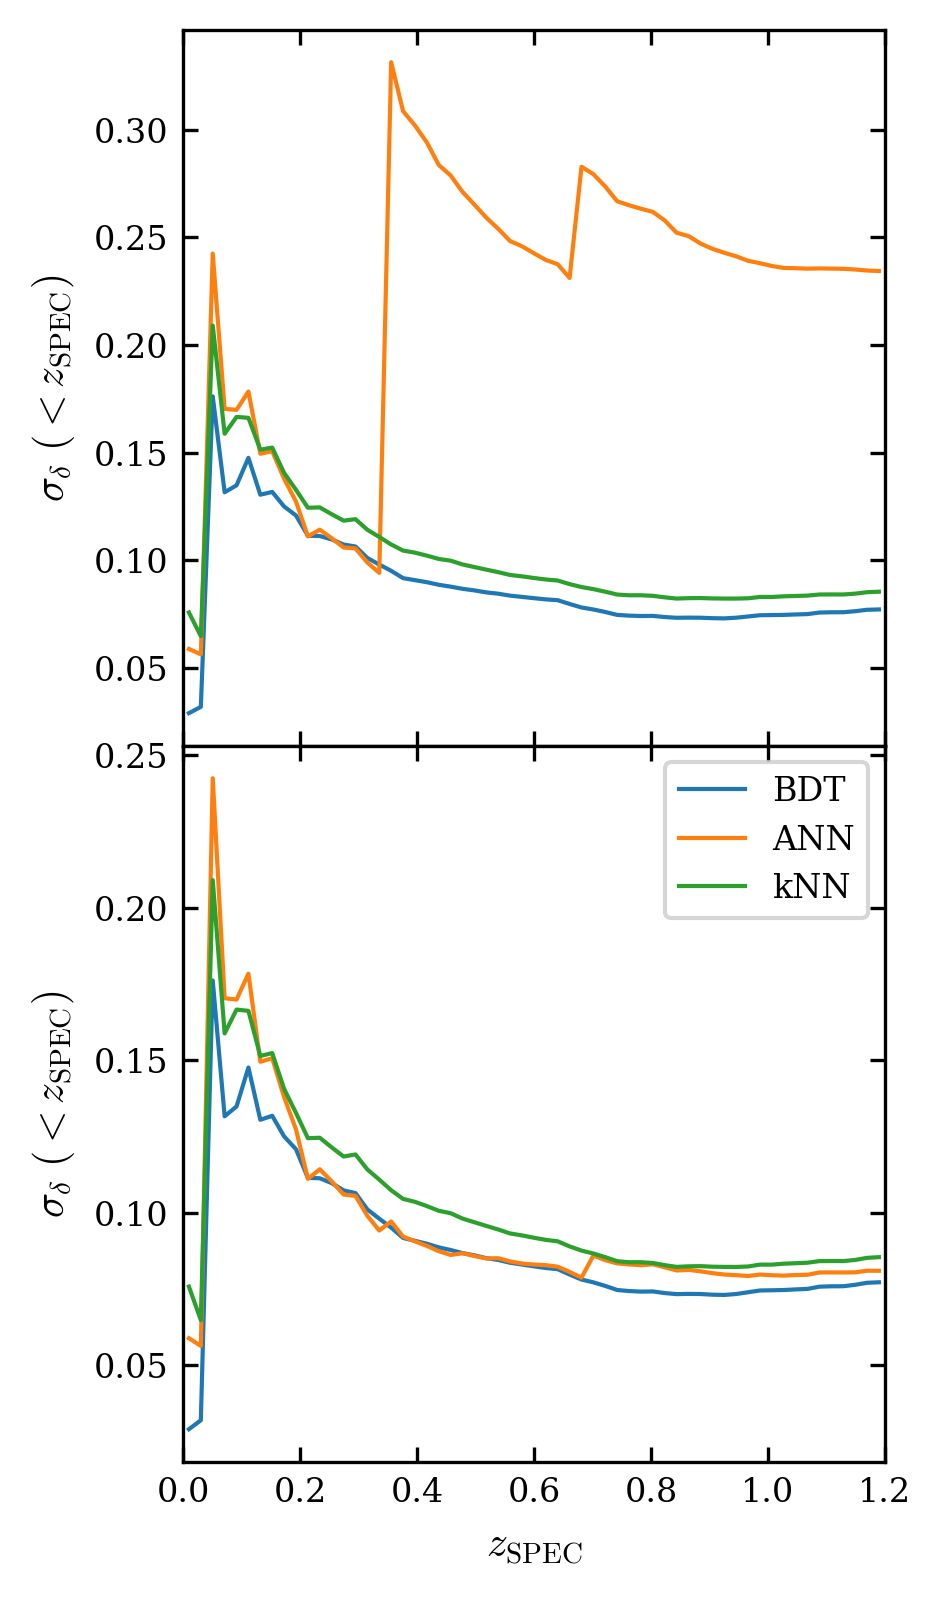

In [13]:
factor = latex_textwidth/72 * 0.5

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(factor,factor*2),dpi=300,sharex=True)

axs = (ax1,ax2)

for i,ax in enumerate(axs):

    cum_std = []
    for objs in data_objs:
        tmp_cumstd = []
        annz,annz_es,spec = objs
        if i == 0: mask = np.ones_like(annz,dtype=bool)
        else:
            mask = abs(annz) < 2
        
        annz,annz_es,spec = annz[mask],annz_es[mask],spec[mask]
        
        for z in zbins[1:]:
            tmp_cumstd.append( cumulative_sigmadelta(spec,annz,z) )

        cum_std.append(tmp_cumstd) 

    cum_std = np.array(cum_std)

    for ind,l in enumerate(cum_std):
        ax.plot((zbins[1:]+zbins[:-1])/2,l,linestyle='-',label='{}'.format(MLM_names[MLMs[ind]]))
    
ax2.set_xlim((0,1.2))
ax2.set_xlabel(r'$z_\mathrm{SPEC}$')
for ax in (ax1,ax2): ax.set_ylabel(r'$\sigma_{\delta}\ (<z_\mathrm{SPEC})$')
ax2.legend(loc='upper right')
plt.subplots_adjust(left=0.16,hspace=0)
custom_SAVEFIG('CUMULATIVE_SIGMA_DELTA_RANDREG_APPENDIX')
plt.show()

In [11]:
p = pd.DataFrame(np.array(data_objs[1]).T,columns=['annz','errors','spec'])

cut = p.loc[abs(p['annz'])<2]
np.std(normed_error(cut['annz'],cut['spec']))

# p.sort_values('annz')

0.0810328989987902

# Comining algorithms (section 5.2)

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

Save figure? (y/n)y
Figure is saved as 20190423_010850_RAND_REG_MULTI_ALG_COMPARISON.png


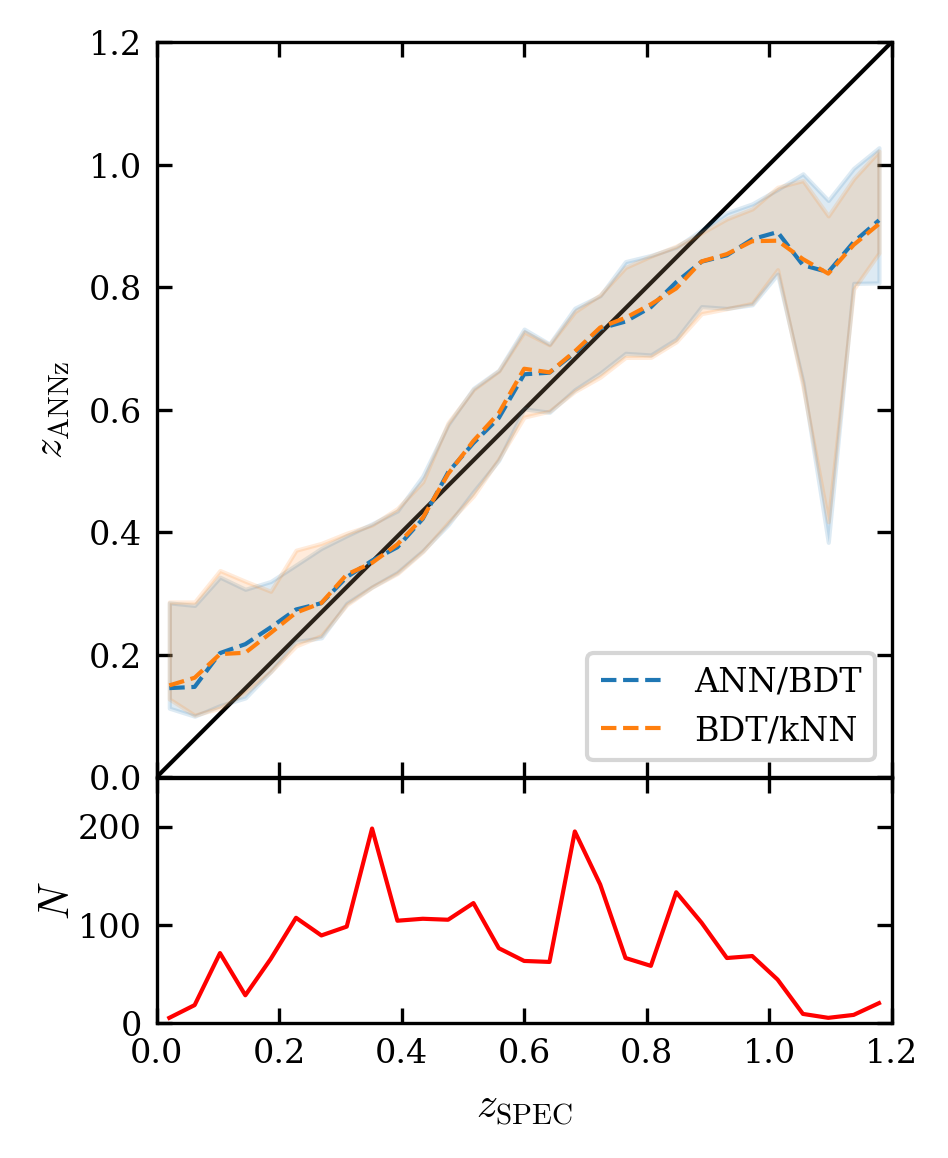

In [109]:

MLMs = ['SPEC_advanced4','SPEC_advanced24']
MLM_names = {'SPEC_advanced4':'ANN/BDT',
             'SPEC_advanced24':'BDT/kNN'}
stats = []
data_objs = []

for mlm in MLMs:
    tmp_df = pd.read_csv("../../ML runs/{}/ANNZ_randomReg_0000.csv".format(mlm),header=0)
    out1, out2 = compute_error_stats_spec(tmp_df)
    stats.append(out1)
    data_objs.append(out2)
    
column_labels = [r"$\langle \delta \rangle $",r"$\sigma_\delta$",r"$\sigma_{68}$",r"$\xi$"]
stats = pd.DataFrame(stats,columns=column_labels)
MLMnamesDF = pd.DataFrame(list(MLM_names.values()),columns=['Alg Type'])
stats = MLMnamesDF.join(stats)
    
N_points = 100
indices = np.random.choice(data_objs[0][0].size,N_points,replace=False)
factor = latex_textwidth/72*0.5
fig, axs = plt.subplots(2,1,figsize=(factor,1.37*factor),dpi=300,sharex=True\
                        ,gridspec_kw = {'height_ratios':[3, 1]})
# axs = [axs]
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# axs = [ax1,ax2]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# colors = ['blue','orange','green']

medians = []

ind=0
for inda,objs in enumerate(data_objs):
    min_bin, max_bin, N_bin = 0.0,1.2,30
    bins = np.linspace(min_bin, max_bin, N_bin)
    
    meds,edge,counts = scipy.stats.binned_statistic(objs[2],objs[0],'median',bins=bins)
    lbs = scipy.stats.binned_statistic(objs[2],objs[0],lb68,bins)[0]
    ubs = scipy.stats.binned_statistic(objs[2],objs[0],ub68,bins)[0]
    
    medians.append(meds)

#     axs[ind].text(0.15,0.9,'{}'.format(MLM_names[MLMs[ind]]),horizontalalignment='center',\
#         verticalalignment='center', transform=axs[ind].transAxes,fontsize=10)
    
#     axs[ind].errorbar(objs[2][indices],objs[0][indices],yerr=objs[1][indices]\
#                  ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw',zorder=1,color=colors[inda])
    axs[ind].plot((bins[:-1]+bins[1:])/2,meds,'--',color=colors[inda],\
                  label='{}'.format(MLM_names[MLMs[inda]]),zorder=10,linewidth=1)
    
    axs[ind].fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=5,\
                          color=colors[inda],\
                          linestyle='-')
    
    

    axs[ind].set_ylabel(r'$z_\mathrm{ANNz}$')
    
#     axs[ind].set_xlim(0.0,1.2)
    axs[ind].set_ylim(0.0,1.2)
    
    axs[ind].set_aspect('equal')
    
#     axs[ind].set_yticks(axs[ind].get_yticks()[:-1])

axs[ind].plot([0,1.2],[0,1.2],'k-',zorder=1)

unique, counted = np.unique(counts, return_counts=True)
axs[1].plot((bins[:-1]+bins[1:])/2,counted[:],'r-',zorder=5)

axs[-1].set_xlim(0.0,1.2)
axs[-1].set_xlabel(r'$z_\mathrm{SPEC}$')
# axs[1].yaxis.la
axs[0].legend(loc='lower right')

axs[1].set_ylabel('$N$',labelpad=0.1)
axs[1].set_ylim((0,250))

fig.subplots_adjust(hspace=0)
custom_SAVEFIG('RAND_REG_MULTI_ALG_COMPARISON')
plt.show()

In [110]:
SSR = []
for ind,objs in enumerate(medians):
    SSR.append(sumsqresid(objs,(bins[1:]+bins[:-1])/2))
    
print(SSR)

[0.35160124009699917, 0.3609432583295692]


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

Save figure? (y/n)y
Figure is saved as 20190423_010959_ML_ERROR_RAND_REG_MULTI_ALG_COMPA.png


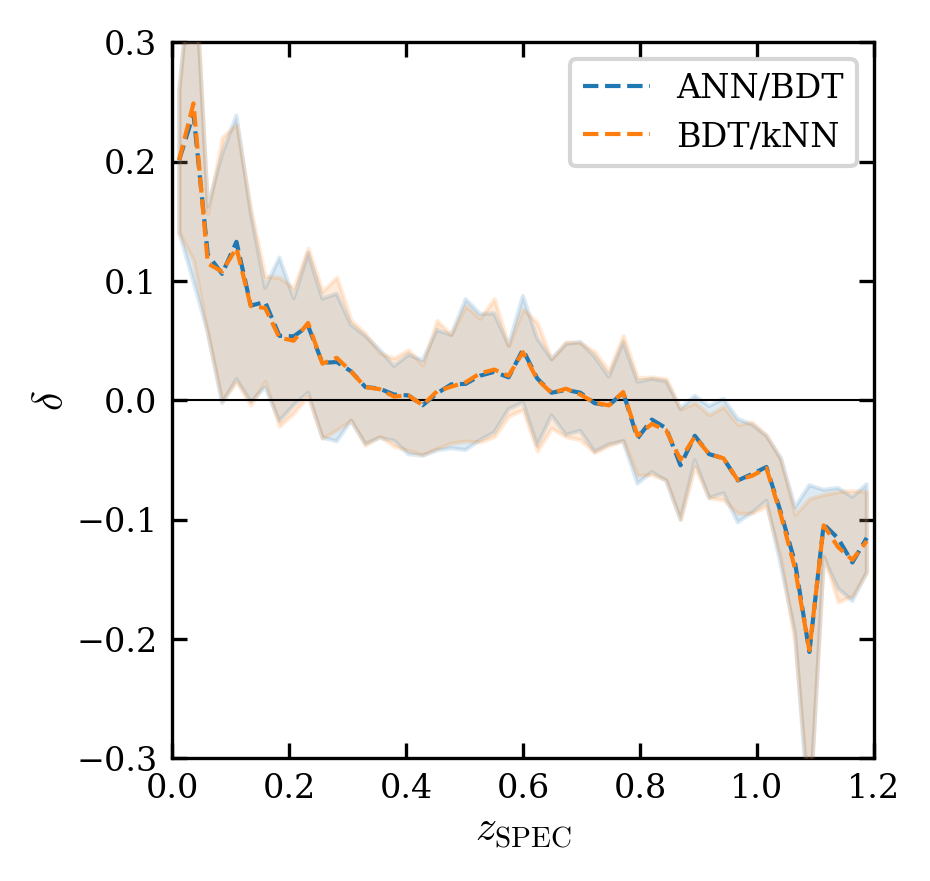

In [112]:
bins = np.linspace(0.0,1.2,50)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 350
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

means = []

for inda,objs in enumerate(data_objs):
    
    all_errors = normed_error(objs[0],objs[2])
    
    mask = (objs[2]<1.2) #& (abs(all_errors) < 0.5)
    
    z_paus = objs[2][mask]
    z_annz = objs[0][mask]
    error = normed_error(z_annz,z_paus)
    
    
    mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

    lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
    ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)


    plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color=colors[inda])
#     hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
#     norm=matplotlib.colors.LogNorm()
    plt.plot((bins[1:]+bins[:-1])/2,mean,'--',color=colors[inda],zorder=10,label='{}'.format(MLM_names[MLMs[inda]]))

    means.append(mean)


plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_\mathrm{SPEC}$')

# plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.0,1.2)
plt.ylim(-0.3,0.3)

plt.subplots_adjust(left=0.16)

# plt.colorbar(hist[3])
plt.legend()
# plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
custom_SAVEFIG('ML_ERROR_RAND_REG_MULTI_ALG_COMPA')
plt.show()

In [114]:

# results = pd.DataFrame(np.array(stats)[None,:],columns=column_labels)
# results.style.format({column_labels[0]: "\${:.2E}\$ &", column_labels[1]: '\${:.3f}\$ &', column_labels[2]: '\${:.3f}\$ &', column_labels[3]: '\${:.2f}\%\$'})
stats.style.format({column_labels[0]: "\${:.2E}\$ &", column_labels[1]: '\${:.3f}\$ &', column_labels[2]: '\${:.3f}\$ &', column_labels[3]: '\${:.2f}\%\$'})

,Alg Type,$\langle \delta \rangle $,$\sigma_\delta$,$\sigma_{68}$,$\xi$
0,ANN/BDT,\$6.60E-03\$ &,\$0.076\$ &,\$0.052\$ &,\$4.93\%\$
1,BDT/kNN,\$6.29E-03\$ &,\$0.075\$ &,\$0.052\$ &,\$4.75\%\$


In [115]:
means_arr = np.array(means)

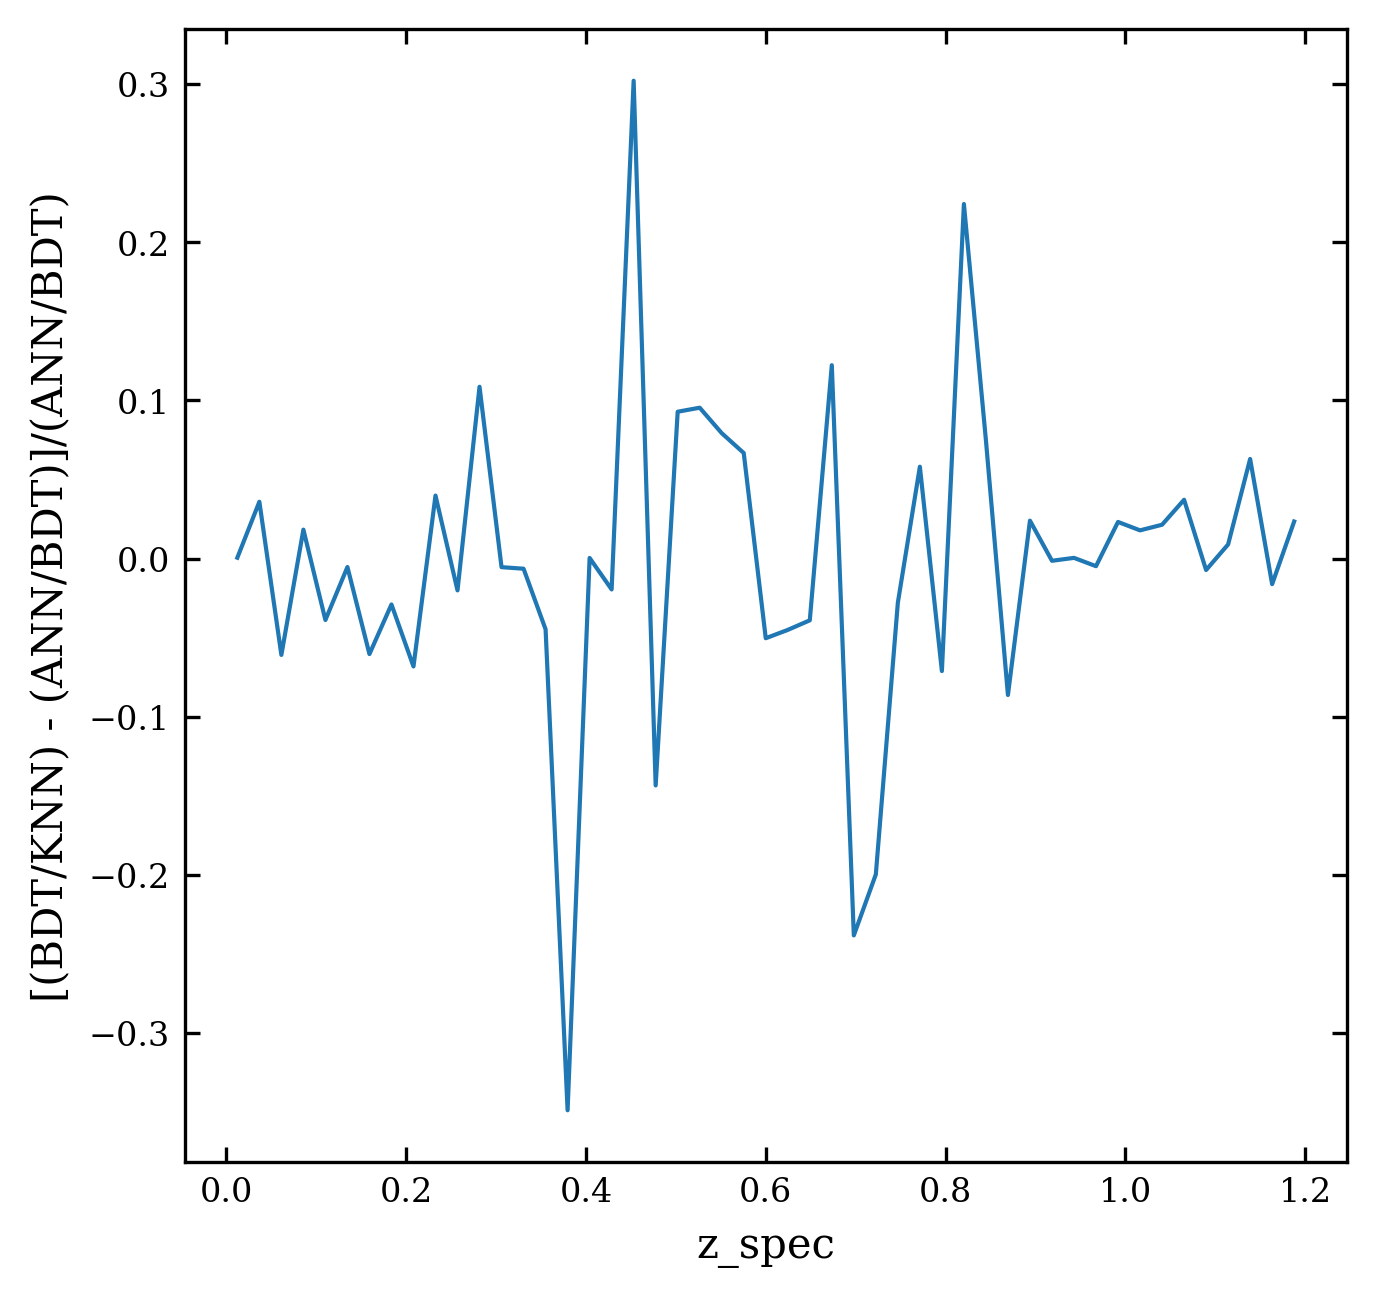

In [116]:
plt.figure(figsize=(5,5),dpi=300)
plt.plot((bins[1:]+bins[:-1])/2,(means_arr[1] - means_arr[0])/means_arr[0],)
plt.xlabel('z_spec')
plt.ylabel('[(BDT/KNN) - (ANN/BDT)]/(ANN/BDT)')
plt.show()

# Comparison with Eriksen (Section 5.3)

In [120]:
df = pd.read_csv('../../ML runs/SPEC_advanced10/ANNZ_randomReg_allPAUS2.csv')
# df_annz = df_annz.iloc[:,:5]



In [121]:
# df_annz.columns.values

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Save figure? (y/n)y
Figure is saved as 20190423_012220_RAND_REG_ERIK_COMPARRISON.png


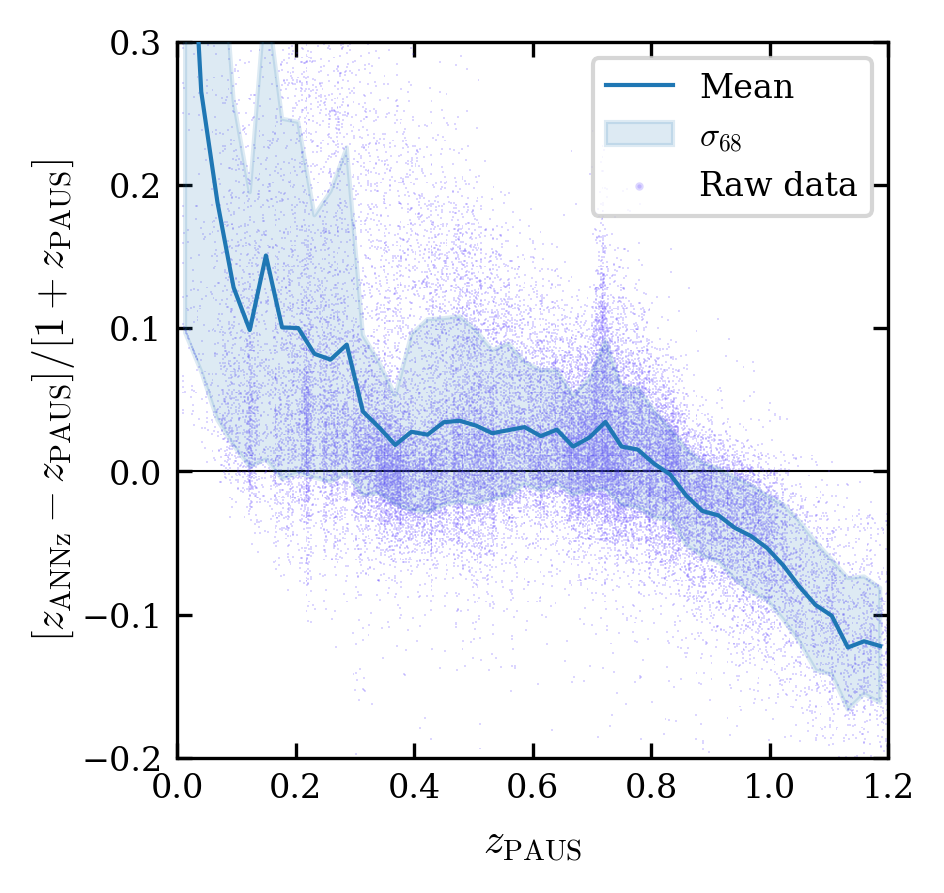

In [125]:
z_paus = df['F:zb']
z_annz = df['F:ANNZ_best']

bins = np.linspace(0.0,1.2,45)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 750
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

means = []

# z_paus = df_annz['F:zb']
# z_annz = df_annz['F:ANNZ_best']

mask = (z_paus<1.2) #& (abs(all_errors) < 0.5)

z_paus = z_paus[mask]
z_annz = z_annz[mask]
error = normed_error(z_annz,z_paus)


mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)

yaxislims = [-0.2,0.3]
mask2 = (error < yaxislims[1]) & (error>yaxislims[0])

plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color=colors[0],label=r'$\sigma_{68}$')
hist = plt.hist2d(z_paus[mask2],error[mask2],[pixs,pixs],norm=norm,cmap='ClearBlue',zorder=2)
norm=matplotlib.colors.LogNorm()

plt.plot((bins[1:]+bins[:-1])/2,mean,'-',alpha=1,zorder=10,label='Mean')
plt.scatter(-1,-1,color=(r1,g1,b1,alpha),label='Raw data',s=1)

# print(plt.gca().xaxis)
plt.gca().yaxis.set_major_locator(tick.MultipleLocator(0.1))

plt.ylabel(r'$[z_\mathrm{ANNz}-z_\mathrm{PAUS}]/[1+z_\mathrm{PAUS}]$',labelpad=1)
plt.xlabel(r'$z_\mathrm{PAUS}$')
plt.axhline(linewidth=0.5,zorder=1,color='black')
plt.xlim(0,1.2)
plt.ylim(yaxislims)
plt.legend()
plt.subplots_adjust(left=0.15)
# plt.
custom_SAVEFIG('RAND_REG_ERIK_COMPARRISON')
plt.show()


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Save figure? (y/n)y
Figure is saved as 20190423_012656_RAND_REG_ERIK_COMPARRISON_imag.png


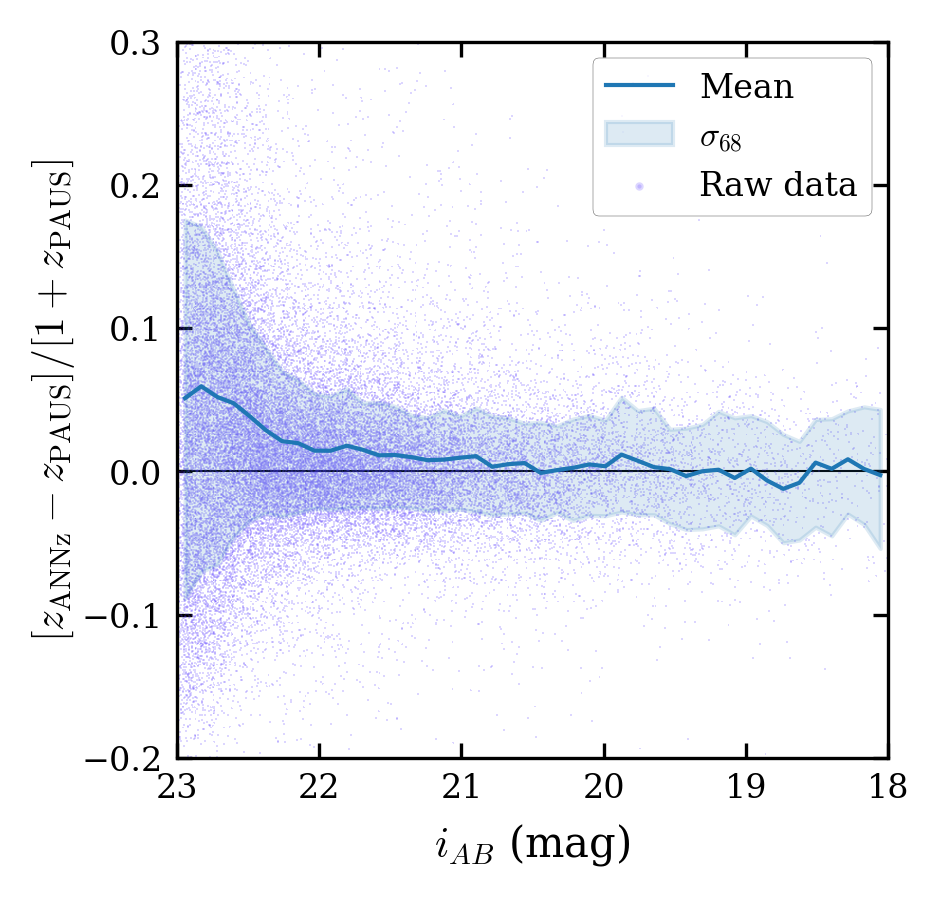

In [126]:
# tmp_df.columns.values

z_paus = df['F:zb']
z_annz = df['F:ANNZ_best']


imags = -2.5*np.log10(df['F:i_auto']) +26

mask = (z_paus<1.2) & (imags>=18)#& (abs(all_errors) < 0.5)

z_paus = z_paus[mask]
z_annz = z_annz[mask]
error = normed_error(z_annz,z_paus)
imags = imags[mask]


bins = np.linspace(imags.min(),imags.max(),45)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 750
# pixs = 600
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

means = []



mean,edge,counts = scipy.stats.binned_statistic(imags,error,'mean',bins=bins)

lbs, edge, counts = scipy.stats.binned_statistic(imags,error,lb68,bins=bins)
ubs, edge, counts = scipy.stats.binned_statistic(imags,error,ub68,bins=bins)


axis_limsy = [-0.2,0.3]
mask2 = (error < axis_limsy[1]) & (error > axis_limsy[0])

plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=5,color=colors[0],label=r'$\sigma_{68}$')
hist = plt.hist2d(imags[mask2],error[mask2],[pixs,pixs],norm=norm,cmap='ClearBlue',zorder=2)
norm=matplotlib.colors.LogNorm()

plt.plot((bins[1:]+bins[:-1])/2,mean,'-',alpha=1,zorder=10,label='Mean')
plt.scatter(-1,-1,color=(r1,g1,b1,alpha),label='Raw data',s=1)

# print(plt.gca().xaxis)
plt.gca().yaxis.set_major_locator(tick.MultipleLocator(0.1))

plt.ylabel(r'$[z_\mathrm{ANNz}-z_\mathrm{PAUS}]/[1+z_\mathrm{PAUS}]$',labelpad=1)
plt.xlabel(r'$i_{AB}$ (mag)')
plt.axhline(linewidth=0.5,zorder=1,color='black')
# plt.xlim(0,1.2)
plt.ylim(axis_limsy)
leg = plt.legend(edgecolor=(0,0,0,1))
leg.get_frame().set_linewidth(0.1)

plt.subplots_adjust(left=0.15)
plt.gca().invert_xaxis()
# plt.
custom_SAVEFIG('RAND_REG_ERIK_COMPARRISON_imag')
plt.show()


# Discussion

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

Save figure? (y/n)


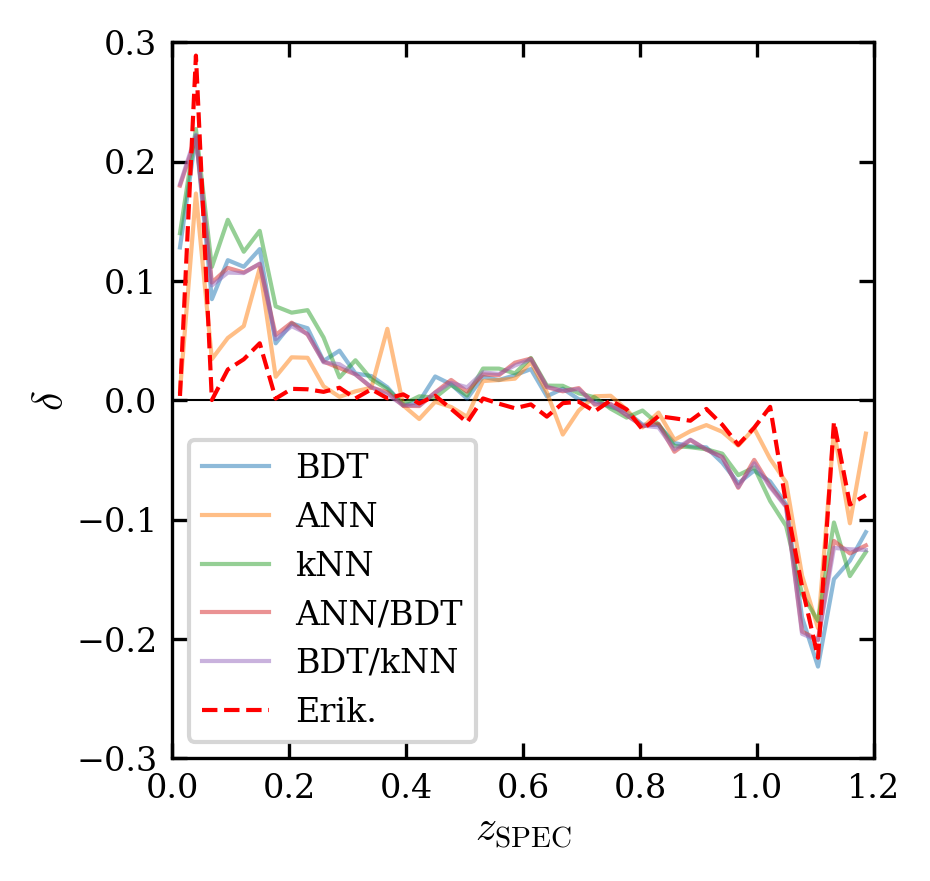

In [117]:
MLMs = ['SPEC_advanced19','SPEC_advanced23','SPEC_advanced5','SPEC_advanced4','SPEC_advanced24']
MLM_names = {'SPEC_advanced19':'BDT',
             'SPEC_advanced23':'ANN',
             'SPEC_advanced5':'kNN',
             'SPEC_advanced4':'ANN/BDT',
             'SPEC_advanced24':'BDT/kNN'}

stats = []
data_objs = []

for mlm in MLMs:
    tmp_df = pd.read_csv("../../ML runs/{}/ANNZ_randomReg_0000.csv".format(mlm),header=0)
    out1, out2 = compute_error_stats_spec(tmp_df)
    stats.append(out1)
    data_objs.append(out2)
    
    
eriksen_stats, erik_objs = compute_error_stats_erik(tmp_df)
# data_objs.append(erik_objs)
    
column_labels = [r"$\langle \delta \rangle $",r"$\sigma_\delta$",r"$\sigma_{68}$",r"$\xi$"]
stats = pd.DataFrame(stats,columns=column_labels)
MLMnamesDF = pd.DataFrame(list(MLM_names.values()),columns=['Alg Type'])
stats = MLMnamesDF.join(stats)

bins = np.linspace(0.0,1.2,45)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(factor,factor),dpi=300)
pixs = 350
bounds = [0,0.9,1e6]
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

means = []

for inda,objs in enumerate(data_objs):
    
    all_errors = normed_error(objs[0],objs[2])
    
    mask = (objs[2]<1.2) #& (abs(all_errors) < 0.5)
    
    z_paus = objs[2][mask]
    z_annz = objs[0][mask]
    error = normed_error(z_annz,z_paus)
    
    
    mean,edge,counts = scipy.stats.binned_statistic(z_paus,error,'mean',bins=bins)

    lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
    ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)


#     plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color=colors[inda])
#     hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
#     norm=matplotlib.colors.LogNorm()
    plt.plot((bins[1:]+bins[:-1])/2,mean,'-',alpha=0.5,color=colors[inda],zorder=10,label='{}'.format(MLM_names[MLMs[inda]]))

    means.append(mean)




mean,edge,counts = scipy.stats.binned_statistic(erik_objs[2],normed_error(erik_objs[0],erik_objs[2]),'mean',bins=bins)
# lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
# ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)
#     plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.15,zorder=3,color=colors[inda])
#     hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
#     norm=matplotlib.colors.LogNorm()
plt.plot((bins[1:]+bins[:-1])/2,mean,'--',color='red',zorder=30,label='Erik.')

    

plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_\mathrm{SPEC}$')

# plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
plt.xlim(0.0,1.2)
plt.ylim(-0.3,0.3)

# plt.colorbar(hist[3])
plt.legend(loc='lower left')
# plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
plt.subplots_adjust(left=0.16)
custom_SAVEFIG('ML_ERROR_OVERALL_COMPARRISON')
plt.show()

In [118]:
df = pd.read_csv('../../ML runs/SPEC_advanced10/ANNZ_randomReg_0000.csv',header=0)

mystats, objs = compute_error_stats_spec(df)


print(eriksen_stats)
# mystats = stats.iloc[4,1:].values
string = ""
print("{:.2E}".format(eriksen_stats[0])[:5])
for i in (mystats,eriksen_stats):
    
    string += r"${}$ & ${:.3f}$ & ${:.3f}$ & ${:.2f}\%$ \\ \hline ".format("{:.2E}".format(i[0])[:4],i[1],i[2],i[3])

print(string)

[-0.003905520866874018, 0.06489158176695857, 0.0146658754279022, 2.867383512544803]
-3.91
$4.69$ & $0.066$ & $0.040$ & $3.36\%$ \\ \hline $-3.9$ & $0.065$ & $0.015$ & $2.87\%$ \\ \hline 


In [119]:
combo = df.merge(data,left_on='F:ref_id',right_on='ref_id')
print(combo.loc[combo['zspec']!=0]['i_auto'].min(),combo.loc[combo['zspec']!=0]['i_auto'].max())

16.928 22.799


# Appendix run log

In [56]:
Table = pd.read_csv("../../ML runs/Run Log.csv",header=0)

In [57]:
shortened = Table.sort_values('Short code').loc[:,'Short code':'nMLMs']

n_entrys = shortened.values.shape[0]

# print(*shortened.values[0])
n_rows = np.floor(n_entrys/2).astype('int')
for i in range(n_rows):
    
    if n_entrys % 2 ==1: ent1, ent2 = i, i+n_rows+1
    else: ent1, ent2 = i, i+n_rows
    
    print("{} & ${}$ & {} & ${}$ & {} & ${}$ & {} & ${}$ \\\\".format(*shortened.values[ent1],*shortened.values[ent2]))

if n_entrys % 2 ==1: print("{} & ${}$ & {} & ${}$ & & & & \\\\".format(*shortened.values[n_rows]))

PR02 & $4$ & BDT & $10$ & SR05 & $10$ & kNN & $50$ \\
PR03 & $5$ & BDT & $10$ & SR06 & $10$ & BDT & $20$ \\
PR06 & $5$ & BDT & $53$ & SR07 & $10$ & BDT & $40$ \\
PR07 & $5$ & BDT & $50$ & SR08 & $10$ & BDT & $60$ \\
PR08 & $6$ & BDT & $50$ & SR09 & $10$ & BDT & $80$ \\
PR09 & $6$ & BDT & $50$ & SR10 & $10$ & BDT & $100$ \\
PR10 & $8$ & BDT & $25$ & SR11 & $10$ & BDT & $125$ \\
PR11 & $8$ & BDT & $25$ & SR15 & $10$ & BDT & $5$ \\
PR12 & $8$ & BDT & $25$ & SR16 & $10$ & BDT & $10$ \\
PR13 & $8$ & BDT & $25$ & SR17 & $10$ & BDT & $100$ \\
PR14 & $8$ & ANN & $20$ & SR18 & $10$ & BDT & $30$ \\
PR17 & $9$ & ANN & $20$ & SR19 & $10$ & BDT & $50$ \\
PR18 & $9$ & ANN/BDT & $20$ & SR20 & $10$ & BDT & $70$ \\
PS01 & $5$ & BDT & $1$ & SR21 & $10$ & BDT & $90$ \\
PS03 & $5$ & ANN & $1$ & SR22 & $10$ & BDT & $110$ \\
PS04 & $5$ & kNN & $1$ & SR23 & $10$ & ANN & $25$ \\
SR01 & $7$ & BDT & $100$ & SR24 & $10$ & BDT/kNN & $50$ \\
SR03 & $10$ & BDT & $25$ & SS01 & $7$ & BDT & $1$ \\
SR04 & $10$ & ANN/BD

# Appendix summary error stats

In [78]:
Table = pd.read_csv("../../ML runs/errorstatssum.csv",header=0).sort_values('code')

In [79]:
Table

,code,SR_RR,RefDS,NMLMs,Alg,MNE,SD,68,XI
3,PR07,RR,P,50,BDT,$1.10$,$0.061$,$0.036$,$2.27$
4,PR09,RR,P,50,BDT,$1.61$,$ 0.029$,$0.020$,$ 0.37$
0,PS01,SR,P,1,BDT,$1.10$,$0.073$,$0.050$,$3.22$
1,PS03,SR,P,1,ANN,$2.60$,$0.069$,$0.046$,$2.58$
2,PS04,SR,P,1,kNN,$6.33$,$0.104$,$0.070$,$8.60$
9,SR04,RR,S,25,ANN/BDT,$6.60$,$0.076$,$0.052$,$4.93$
7,SR05,RR,S,50,kNN,$11.2$,$0.085$,$0.060$,$7.26$
8,SR10,RR,S,100,BDT,$4.69$,$ 0.066$,$0.040$,$ 3.36$
5,SR19,RR,S,50,BDT,$6.94$,$0.077$,$0.051$,$5.06$
6,SR23,RR,S,25,ANN,$2.26$,$0.081$,$0.040$,$3.77$


In [80]:

cutTable = Table.iloc[:,3:]

for ind,i in enumerate(cutTable.values):
    print('{} & ${}$ & {} & {} & {} & {} & {} \\\\'.format(Table.iloc[ind,0],*i) )

PR07 & $50$ & BDT &  $1.10$  &  $0.061$  &  $0.036$  &  $2.27$ \\
PR09 & $50$ & BDT & $1.61$ & $ 0.029$ & $0.020$ & $ 0.37$ \\
PS01 & $1$ & BDT  &  $1.10$  &  $0.073$  &  $0.050$  &  $3.22$ \\
PS03 & $1$ & ANN  &  $2.60$  &  $0.069$  &  $0.046$  &  $2.58$ \\
PS04 & $1$ & kNN  &  $6.33$  &  $0.104$  &  $0.070$  &  $8.60$ \\
SR04 & $25$ & ANN/BDT  &  $6.60$  & $0.076$  & $0.052$  & $4.93$  \\
SR05 & $50$ & kNN  &  $11.2$  &  $0.085$  &  $0.060$  &  $7.26$ \\
SR10 & $100$ & BDT & $4.69$ &  $ 0.066$ &  $0.040$  & $ 3.36$ \\
SR19 & $50$ & BDT  &  $6.94$  &  $0.077$  &  $0.051$  &  $5.06$  \\
SR23 & $25$ & ANN  &  $2.26$  &  $0.081$  &  $0.040$  &  $3.77$  \\
SR24 & $50$ & BDT/kNN  &  $6.29$  & $0.075$  & $0.052$  & $4.75$  \\
